#VISUALISATIE 3 NETWERK GUIDO GEZELLE

##INTRO

Dit voorbeeld is een netwerkvisualisatie omtrent Guido Gezelle met beschikbare data op Wikidata. In deze handleiding wordt uitgelegd hoe twee aan elkaar gerelateerde visualisaties te maken. De eerste toont een bipartiet of tweemodaal-netwerk omtrent het netwerk van Guido Gezelle op vlak van gemeenschappelijke verenigingen, werkplaatsen en onderwijsinstellingen (personen-instelling). In een latere fase kijken we hier ook naar een tweede visualisatie, namelijk de projectie tot een eenmodaal netwerk (persoon-persoon). Dit eenmodale netwerk toont de "institutionele cohesie": personen zijn met bepaalde sterkte verbonden als ze een of meerdere instituten delen.

##VRAAGSTELLING

 wie zijn alle personen die brieven hebben gestuurd of ontvangen van Guido Gezelle en hoe zijn deze gegroepeerd per vereningen? Welke gemeenschappelijke verenigingen, werkplaatsen en onderwijsinstellingen deelden de leden van Gezelles netwerk? en hoe sterk is deze institutionele cohesie?

##QUERIES

Om deze vragen te beantwoorden zullen we gebruik maken van de informatie die beschikbaar is op Wikidata omtrent Guido Gezelle. Op Wikidata is veel informatie verzameld en volgens een specifiek relationeel model gestructureerd. Zo kan data eenvoudig aan elkaar gelinkt worden en in relatie tot elkaar opgevraagd worden.

Hiervoor gebruiken we de Wikidata Query service. In deze service is het mogelijk om queries te ontwerpen op basis van codetaal. De codetaal die hiervoor gebruikt wordt, is SPARQL. Over deze codetaal is veel documentatie terug te vinden. Hieronder hebben we enkele queries opgesteld met behulp van deze service. Daarnaast hebben we ook gebruik gemaakt van generatieve AI, in dit geval Gemini om de queries te stroomlijnen of wat tijd uit te sparen bij het testen van enkele varianten.

Opmerking: de rekencapaciteit van Wikidata Query Service is snel overbelast. Queries mogen dus niet te uitgebreid of complex zijn. Dit zorgt voor server overload. Om die reden worden in deze voorbeelden de vraagstelling opgedeeld in verschillende deelvragen, die elk met een simpele query beantwoord kunnen worden.

Voor deze visualisatie worden twee queries gebruikt. De eerste geeft alle personen die correspondent zijn van Guido Gezelle weer, alsook van wie Guido Gezelle de correspondent is. Daarnaast worden ook beroep en link naar afbeelding opgevraagd. De tweede query haalt de relaties op tussen correspondenten en hun instituten (vereniging, werkplaats, onderwijs)

###Query1

In [ ]:
# Visualisatie 3 Query 1: Extractie van Correspondent-Nodes en Attributen (Beroep, afbeelding)
SELECT DISTINCT
?lid?lidLabel?beroep?beroepLabel?imageLink
WHERE
{
  BIND(wd:Q336977 AS ?gezelle)
  BIND(wd:Q3589290 AS ?correspondent)

  # Vind alle correspondenten van Gezelle via P3342 en P3831
  {
     # lid is correspondent
    ?gezelle p:P3342 [ ps:P3342?lid; pq:P3831 ?correspondent ].
  }
  UNION
  {
     #?Guido is correspondent
    ?lid p:P3342 [ ps:P3342?gezelle; pq:P3831 ?correspondent ].
  }

  FILTER(?lid!=?gezelle)

  # Zorg ervoor dat het 'lid' een mens is
?lid wdt:P31 wd:Q5.

  # Haal het beroep op, OPTIONAL om personen zonder beroep niet uit te sluiten
  OPTIONAL {?lid wdt:P106?beroep. }
       OPTIONAL {?lid wdt:P18 ?imageLink}

  SERVICE wikibase:label { bd:serviceParam wikibase:language ",nl,en". }
}

###Query2

In [ ]:
# Visualisatie 3 Query 2: Haal de relaties op tussen correspondenten en hun instituten (vereniging, werkplaats, onderwijs)
SELECT DISTINCT ?person ?personLabel ?institution ?institutionLabel ?institutionTypeLabel ?imageLink
WHERE {
  # Stap 1: Definieer de "Pool" van Gezelle's correspondenten (zelfde als hierboven)
  BIND(wd:Q336977 AS ?guido)
  BIND(wd:Q3589290 AS ?correspondent_role)
  {
    ?guido p:P3342 ?stmt.
    ?stmt ps:P3342 ?person.
    ?stmt pq:P3831 ?correspondent_role.
  } UNION {
    ?person p:P3342 ?stmt.
    ?stmt ps:P3342 ?guido.
    ?stmt pq:P3831 ?correspondent_role.
  }
  FILTER(?person != ?guido)

  # Stap 2: Vind de institutionele links (Vereniging, Werkplaats, Onderwijs)
  # We gebruiken de properties die je noemde:
  VALUES ?prop {
      wdt:P463 # lid van Vereniging
      wdt:P108  # werkgever Werkplaats
      wdt:P69   # opgeleid bij Onderwijsinstelling
  }

  # De feitelijke relatie: Persoon -> Property -> Instituut
  ?person ?prop ?institution.

  #afbeelding
  OPTIONAL{?institution wdt:P18 ?imageLink.}

  # Stap 3: Haal alle labels op
  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "nl,en".
    ?person rdfs:label ?personLabel.
    ?institution rdfs:label ?institutionLabel.
    ?prop rdfs:label ?institutionTypeLabel. # Dit geeft "lid van", "werkgever", etc.
  }
}

##EXPORT

Vervolgens moet de data gedownload worden en verder worden verwerkt in software zoals Spreadsheets, Excel, OpenRefine, enzvoort. Hier is het doel om een bestand met knopen en een bestand met verbindingen te maken, aangezien dat de twee bouwstenen van de visualisatie worden.

Exporteer de resultaten van de queries uit de Wikidata Query Service. Sla ze op als csv-bestanden. Geef de bestanden een duidelijke naam, bijvoorbeeld V3Q1 en V3Q2.

Open Spreadsheets of Excel en importeer één voor één de verschillende gedownloade bestanden met de resultaten van de queries, elk afzonderlijk als nieuw tabblad in hetzelfde spreadsheet-project. Noem de tabbladen 'RawV3Q1' en 'RawV3Q2'.

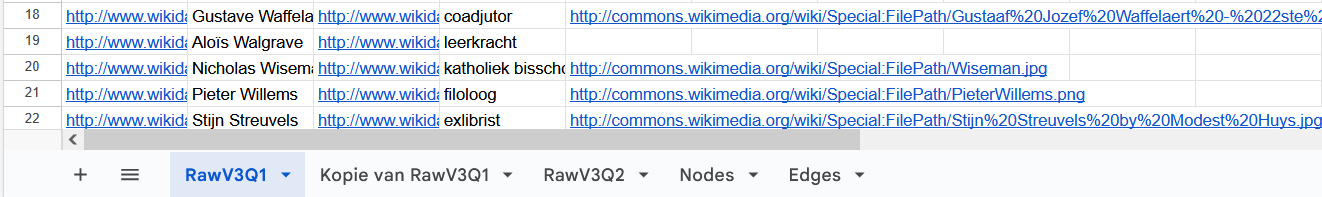

##NODES

Om in Gephi een visualisatie te maken, hebben we een bestand nodig met knopen (nodes) en een bestand met verbindingen (edges). in dit geval zijn er twee soorten knopen: een lijst van alle personen (de correspondenten) en een lijst van alle instituten (de verenigingen, onderwijsinstellingen en werkplaatsen). De edges zijn een lijst van de relaties tussen die personen en instituten.

1. Exporteer de resultaten van Query 1 en Query 2 naar een spreadsheet (bv. Google Spreadsheets). Importeer elk bestand als een apart tabblad en geef het bijvoorbeeld de naam 'RawV3Q1', 'RawV3Q2', enzovoort.

2. Maak een nieuw 'Nodes'-tabblad.

3. Maak een kolom met de naam 'Id' aan: Kopieer wikidata links met Q-nummers uit Query 1. Plak daaronder de ?institution Q-nummers uit Query 2.

4. Wikidata URL's Verwijderen: Dit is erg belangrijk voor Gephi! Het eenvoudigste is om de kolom te selecteren en dan in het menu te kiezen voor 'bewerken' en vervolgens 'zoeken en vervangen' te kiezen. Daar kan je instellen om 'http://www.wikidata.org/entity/' te vervangen door '' (leegte). Hierna blijf je enkel met de Q-nummers over. Daarna kopieer je de kolom en plak je ze terug op dezelfde plaats, maar kies 'enkel waarden plakken' in het submenu.

4. Maak een kolom 'Label' aan: Gebruik ?personLabel en ?institutionLabel op dezelfde manier.

5. Maak een kolom 'Type' aan: Maak een nieuwe kolom. Geef alle rijen die een persoon zijn de waarde "Persoon". Geef alle rijen die een instituut zijn de waarde "Instituut".

6. Maak een kolom 'Beroep' aan: Kopieer de ?beroepLabel kolom uit Query 1 voor de bijbehorende personen. De cellen voor de instituten laat je leeg (of 'n.v.t.').

probleem: een persoon kan meerdere beroepen hebben, maar omdat we maar één waarde per knoop/persoon kunnen toewijzen. De oplossing kan zijn om alle beroepen van een persoon op te lijsten in een cel door deze samen te nemen, bijvoorbeeld onderscheiden door een komma. Dit zorgt er echter voor dat we in de visualisatie niet kunnen selecteren op beroep, omdat elke combinatie een unieke waarde vormt. Gephi kan zo niet herkennen welke mensen een van deze beroepen delen, tenzij de inhoud van de cel identiek is.
Een andere oplossing kan zijn om het hoofdberoep te kiezen en dus maar 1 waarde toe te wijzen als beroep per persoon. Op die manier kunnen we personen opdelen in groepen indien ze hetzelfde hoofdberoep hebben. Uiteraard kost dit veel tijd. In deze case hebben we ervoor gekozen om de beroepen samen in een celwaarde te plaatsen.

7. Celwaarden samenvoegen van beroepen op basis van naam:

Om de verschillende beroepen per persoon te groeperen in één cel, maak je best eerst een kopie van RawV3Q1 in een nieuw tabblad. Vervolgens maak je hierin een nieuwe kolom aan, in dit geval kolom F met de naam 'unieke namen'.

Vervolgens gebruiken we de formule:

`=UNIQUE(B:B) `

om alle unieke namen uit de lijst te filteren. Deze vormen nu afzonderlijke rijen.
Vervolgens kunnen we een nieuwe kolom G aanmaken met de naam 'gecombineerde beroepen'. In deze kolom gebruiken we in cel G3 (naast de eerste naam) de volgende formule:

 ` =JOIN(", "; FILTER($D2:D; $B2:B = F3))`

Als we deze formule toepassen op alle unieke namen (door naar beneden te slepen), hebben we onze lijst met samengevoegde beroepen. Deze kunnen we nu oproepen in het nodes-bestand. We passen de kolom 'beroep' aan in het nodes-bestand met onderstaande formule.

`= VLOOKUP(B2;'Kopie van RawV3Q1'!F:G;2;false)`

Hiermee roepen we de data vanuit de kolom 'gecombineerde beroepen' op naar het nodes-bestand en krijgen we de lijst van beroepen per persoon naar de respectievelijke persoon.

8. Kijk na voor duplicaten en verwijder ze eventueel met de 'data opschonen'-functie.

**Beroepen samenvoegen in een cel**

Zoals eerder vermeld, kunnen we de persoonsknopen ook voorzien van een attribuut waarin alle jobs opgelijst worden. Momenteel zijn deze jobs opgelijst op meerdere rijen. Wat we willen bereiken, is dat een cel de hele lijst aan beroepen bevat, onderscheiden door een komma. Zo zijn alle beroepen in een celwaarde opgenomen in plaats van over meerdere cellen en rijen.

We gaan als volgt te werk: eerst maken we een kopie van de resultaten van Q1, namelijk rawV3Q1. In deze kopie maken we een nieuwe kolom 'unieke namen'.
In deze kolom voegen we deze formule toe en slepen naar beneden.

=UNIQUE(B:B) (B is de kolom met de persoonsnamen in)

We krijgen nu een lijst unieke namen. Om hierbij de beroepen te voegen, maken we eerst nog een nieuwe kolom aan en noemen deze 'samengevoegde namen'. Hierin plakken we deze formule naast de eerste naam:

=JOIN(", "; FILTER($D2:D; $B2:B = F3))

dit leest: "Haal alle waarden op uit kolom D(beroepen), voor de rijen waar kolom B (namen) overeenkomt met de waarde in cel F3 (unieke naam), en plak ze aan elkaar met een komma en een spatie ertussen."

Vervolgens kunnen we deze waarden oproepen in ons nodes-tabblad. Ga naar het nodes-tabblad en maak een nieuwe kolom aan met de naam 'samengestelde beroepen'. geef daaronder deze formule in:

= VLOOKUP(B2;'Kopie van RawV3Q1'!F:G;2;false)

Dit leest: "Zoek de waarde uit cel B2 (naam) exact op in kolom F (unieke eigennamen) van het tabblad 'Kopie van RawV3Q1', en geef de overeenkomstige waarde terug uit kolom G (de samengestelde beroepen)."

Op die manier krijgen we voor elke persoon de lijst aan samengestelde beroepen als een attribuut om in Gephi te gebruiken, alsook in onze visualisatie te tonen.


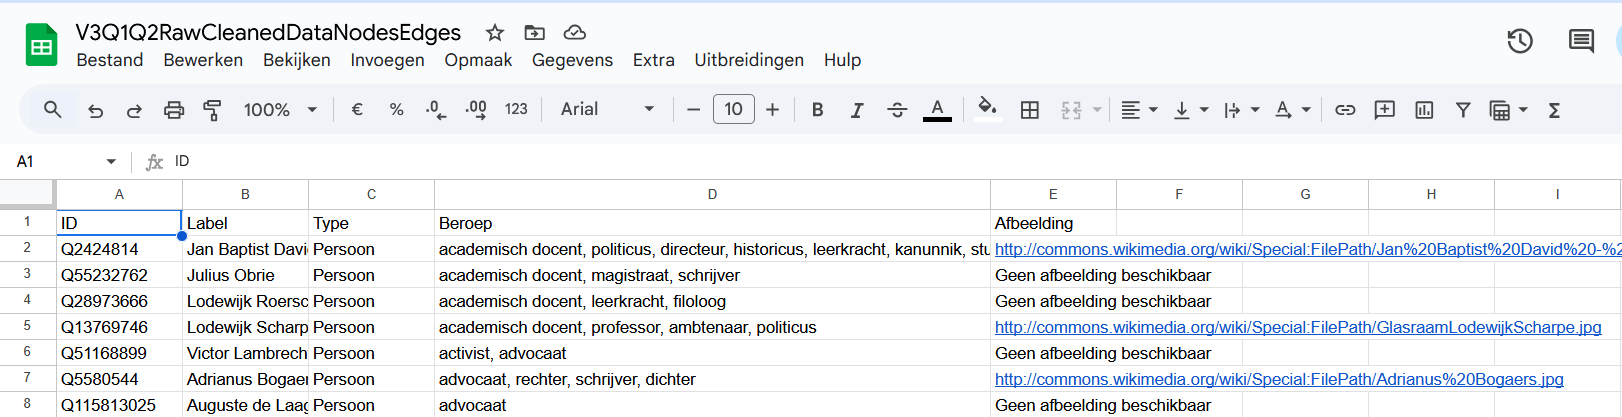

##EDGES

Dit bestand beschrijft alle relaties tussen personen en instituten, rechtstreeks uit Query 2.

1. Maak een 'Edges'-tabblad.
    
2. Maak een kolom 'Source': Dit is de ?person kolom (alleen de Q-nummers) uit Query 2.

3. Maak een kolom 'Target': Dit is de ?institution kolom (alleen de Q-nummers) uit Query 2.

4. Maak een kolom 'Type': Zet dit op 'Undirected' (Ongericht), aangezien de relatie "lid van" in twee richtingen werkt voor dit type analyse.

5. Maak een Kolom 'Label': Gebruik de ?institutionTypeLabel kolom ("lid van", "werkgever", etc.).

opmerking: mogelijk bevat de kolom 'institutionTypeLabel' uit V3Q2 enkel de P-waarden en niet de labels. (Wikidata Query service geeft soms nogal problemen om labels van properties op te halen). Om die reden en het feit dat het maar om 3 verschillende soorten relaties gaat, hebben we er voor gekozen zelf handmatig de properties te hernoemen in het raw bestand. Dit kan simpelweg gedaan worden met de 'zoek en vervang'-functie. Voorbeeld: 'http://www.wikidata.org/prop/direct/P463' vervangen we door 'Vereniging'. Dit herhalen we voor werkgever en onderwijsinstelling.

     wdt:P463 = Vereniging
      wdt:P108 = Werkgever
      wdt:P69 = onderwijsinstelling

Op die manier hebben we een leesbaar overzicht met drie verschillende labels.

6. Exporteer het tabblad met een herkendbaar naam 'V3Aedges.csv'.

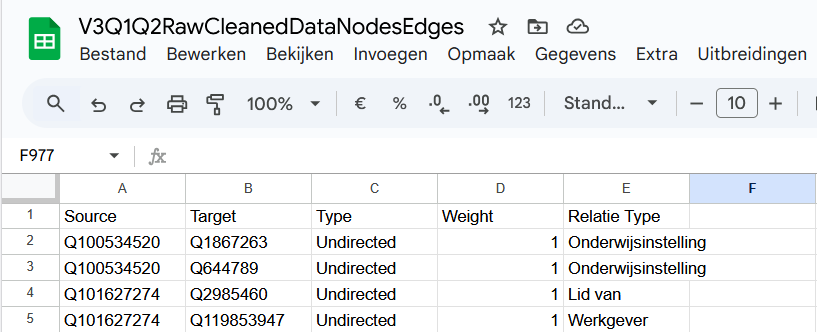

##GEPHI: VISUALISATIE 3A

Nu de knopen en verbindingen in afzonderlijke bestanden zijn opgesteld, is de volgende stap om ze in Gephi in te laden en te visualiseren.

Via de functie 'import spreadsheets' kunnen we eerst het nodes-bestand inladen als een 'nodes table'. Daarna kunnen we hetzelfde doen voor het edges-bestand. Vergeet niet te importeren naar dezelfde worksheet en let erop dat de edges als 'edge table' worden ingeladen. Later kun je in Gephi de data nog verder aanpassen, moesten er toch kleine problemen opduiken. Als het inladen niet lukt, dan moeten de stappen hierboven doorlopen worden. Let goed op de naamgeving van de kolommen en of de kolommen homogene informatie hebben, allemaal zijn ingevuld met een waarde. Kopieer de inhoud van elke kolom en plak die terug als 'waarde'. Allemaal kleine tips om de data in te kunnen laden.


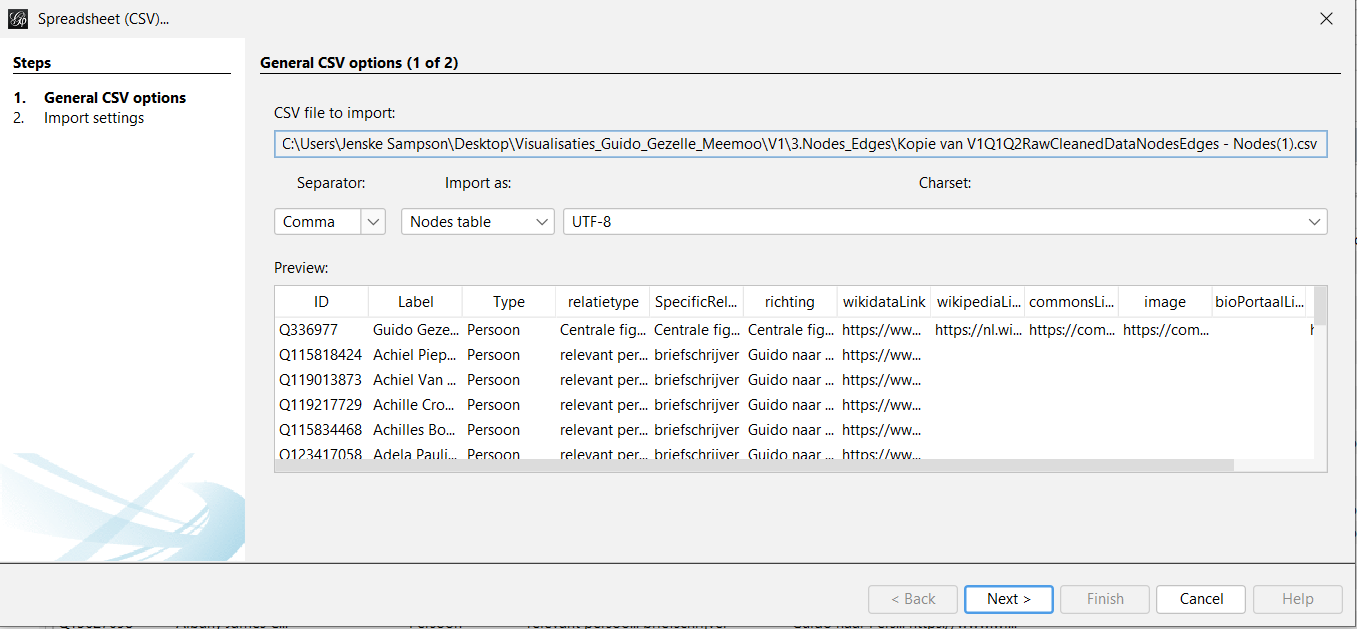

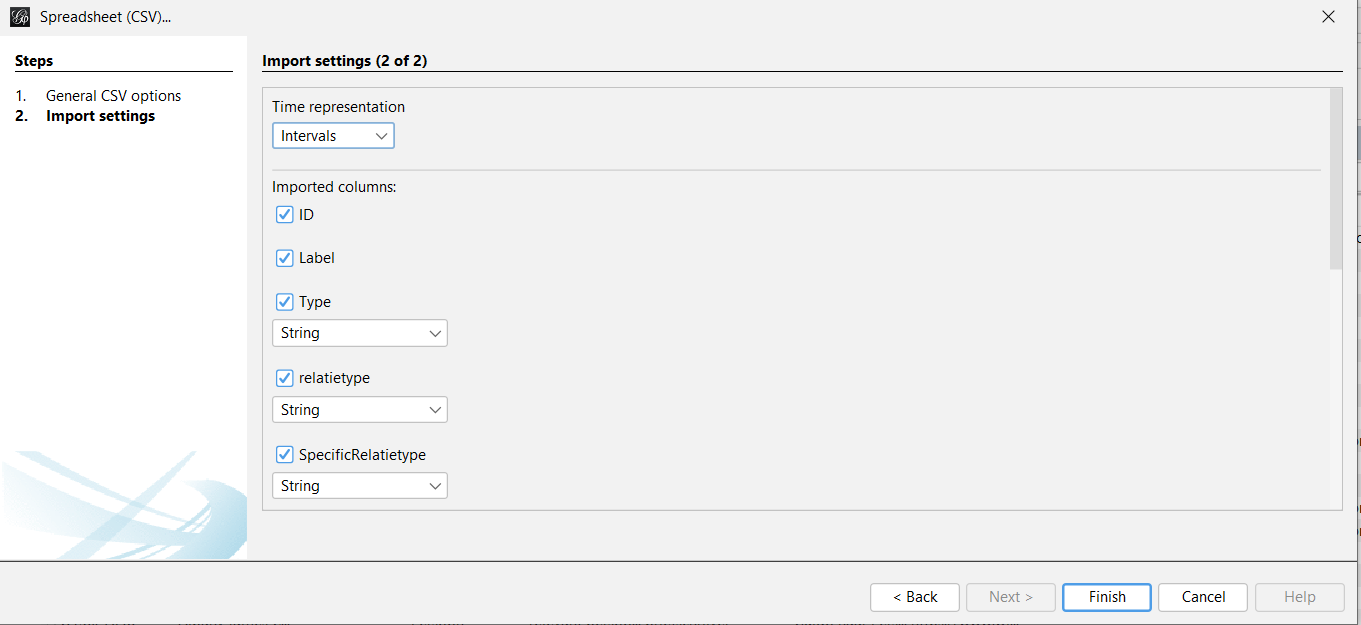

eens de data in ingeladen, kunnen we bij 'overview' kijken naar de cluster van punten en lijnen.

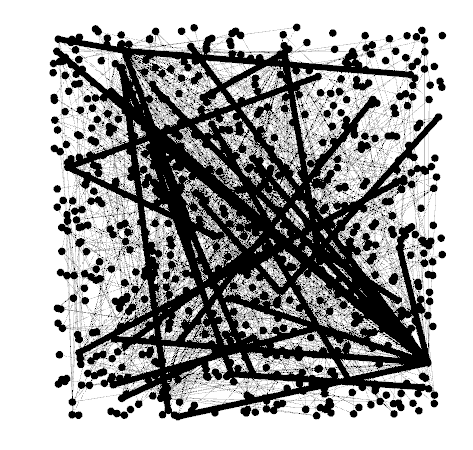

opmerking: Soms krijg je bij het inladen fouten zoals dubbele nodes. In sommige gevallen konden we dit niet onmiddellijk verklaren of oplossen. Op zich kun je gewoon verder inladen en dit oplossen in Gephi zelf. Moesten er toch foutjes zijn in de visualisatie (bijvoorbeeld met grote pijlen/edges), dan kan je in ' data laboratory' naar de 'edge'-tab kijken naar het gewicht van de edges. Je kunt in dit geval alles selecteren door te slepen en met een rechterklik kiezen voor 'edit edges'. Links zul je een menu zien waar je de weight variabele kunt aanpassen. Hier kun je de waarde 1 ingeven voor alle edges. Op die manier zijn alle verbindingen even sterk en ziet de visualisatie er terug 'normaal' uit.

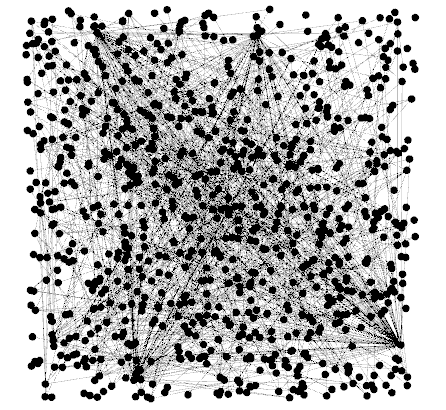

Vervolgens ordenen we de visualisatie. Om tot de gewenste vorm te komen, kun je links bij 'layout' kiezen uit een lijst sorteeralgoritmes.  Hier kiezen we voor ForceAtlas2. Kies dit en pas de 'scaling' aan naar waarde '80' en de 'gravity' naar '125'. Druk op 'Run'. Je kan hierna ook ordenen op 'no overlap' en/of wat andere parameters aanpassen en opnieuw op 'run' klikken. Je krijgt nu onderstaande vorm:

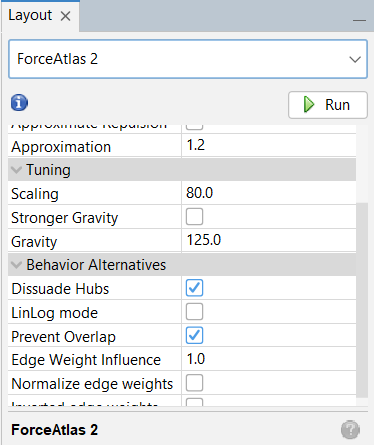

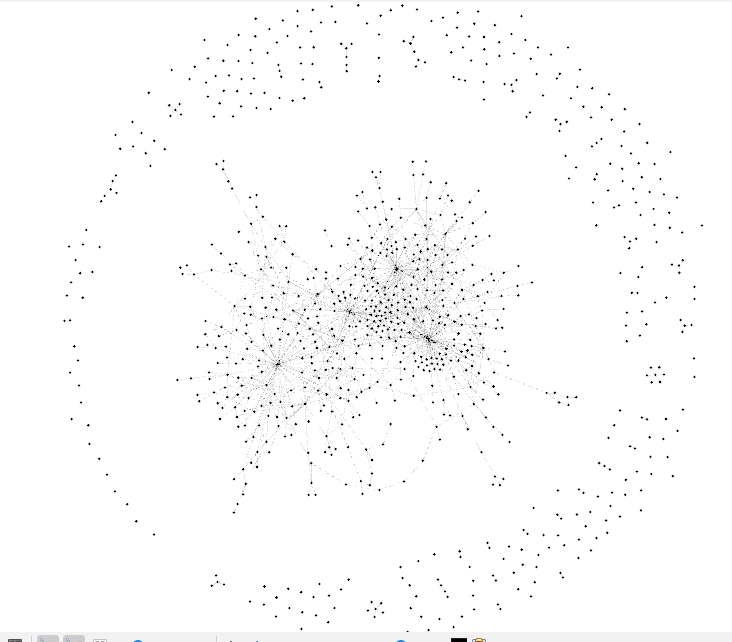

Vervolgens kunnen we ook de grootte en kleur van de knopen en verbindingen aanpassen om de visualisatie intuïtiever te maken. De kleur van de knopen verwijst in dit geval naar het type (persoon of instelling). De grootte wordt bepaald door de 'degree';het aantal verbindingen met andere knopen. Beiden kunnen aangepast worden in het 'appearance'-menu aan de linkerkant. Indien dit niet zichtbaar is, kan het in het hoofdmenu (boven) geselecteerd worden onder het tabblad 'windows'. Je kan 'nodes' selecteren. Vervolgens klik je op de icoontjes naast 'node-edge'. Hier kun je de kleur aanpassen op basis van een attribuut, in dit geval 'type'. Om de grootte aan te passen klik je op het andere icoontje. Daarna kun je kiezen voor attribute 'Degree' en een min size van '20' en max size van '120' instellen. Mogelijk moet je daarna het sorteeralgoritme nogmaals laten draaien.


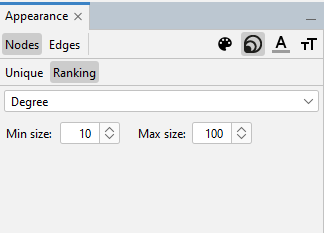

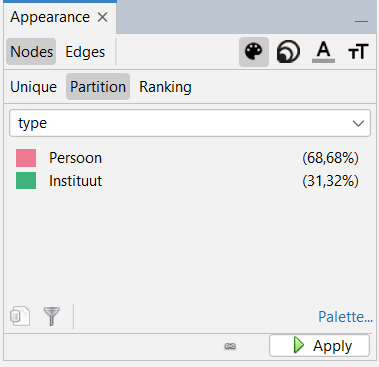

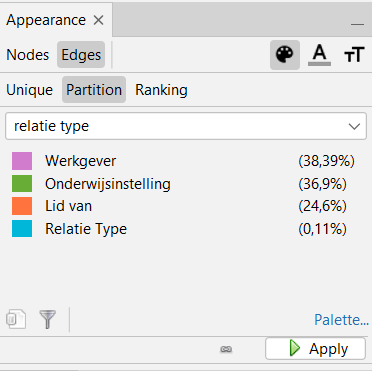

De kleur van de verbindingen wijst op het relatietype, in dit geval werkgever (paars), onderwijsinstelling (oranje) of lid van vereniging (groen). Ook dit kan geselecteerd worden in het 'appearance'-menu, in dit geval onder de 'edges' tab. Daar kies je voor attribuut 'relatiettype' en drukt op 'apply'. Ook de lijndikte van de edges kan aangepast worden. Daarvoor moet in dit geval geschoven met de waarde van het balkje naast het witte 'T' icoontje onder de visualisatie

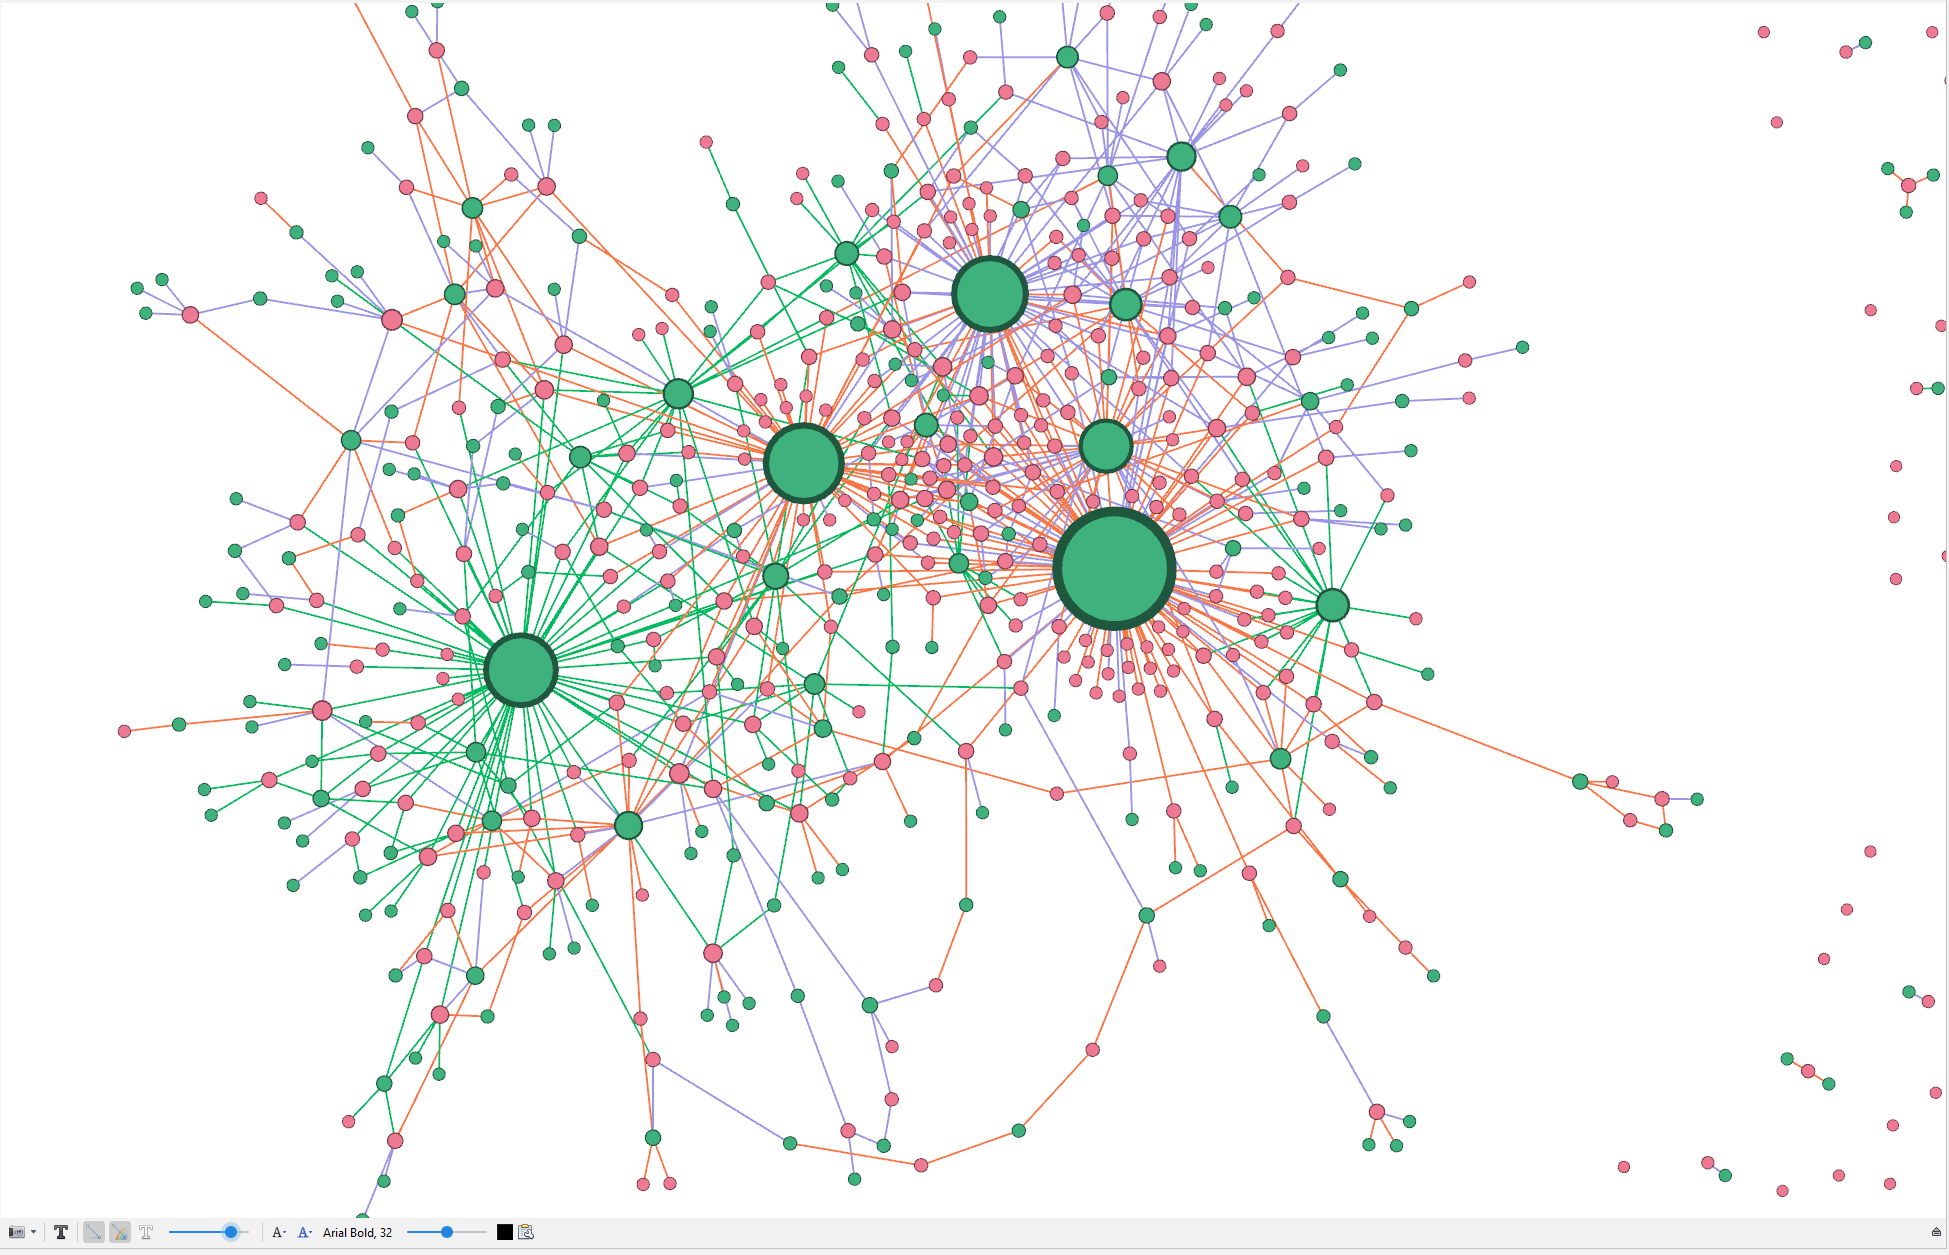

Tot slot kan het nog interessant zijn de verbindingen dikker te maken en de labels enkel zichtbaar te maken voor de geselecteerde knopen. De verbindingen kunnen dikker gemaakt worden in het preview scherm onder 'edges'- 'thickness'. Hier kan je de waarde verhogen. Een andere manier om de verbindingen en de pijlen dikker te maken is via het 'overview'-scherm. Hier kun je onder de visualisatie enkele tools vinden, bijvoorbeeld een grote witte letter 'T'. Door de balk te verschuiven, worden de lijnen dikker. in het hoofdmenu kan naast 'overview' en 'data laboratory' ook gekozen worden voor een 'preview'-menu. Hier kan nog vanalles aangepast worden aan het model. in het bijzonder kun je hier kiezen voor 'curved' in plaats van 'straight' edges. Ook de dikte van de edges kan hier bijvoorbeeld aangepast worden, alsook of labels zichtbaar zijn, lettertypes, enzovoort.


Tot slot kan ook het label zichtbaar gemaakt worden wanneer deze geselecteerd wordt. Alle labels op elk moment tonen wordt te onoverzichtelijk. Om dit te doen, drukken we op het symbooltje rechts onderaan ten opzichte van de visualisatie. Er opent dan een extra menu waar onder het tabblad 'labels' gekozen kan worden voor 'highlight selection'. Vervolgens vinken we links het vakje naast 'Node' aan, om de nodes bij selectie zichtbaar te maken (zie foto).


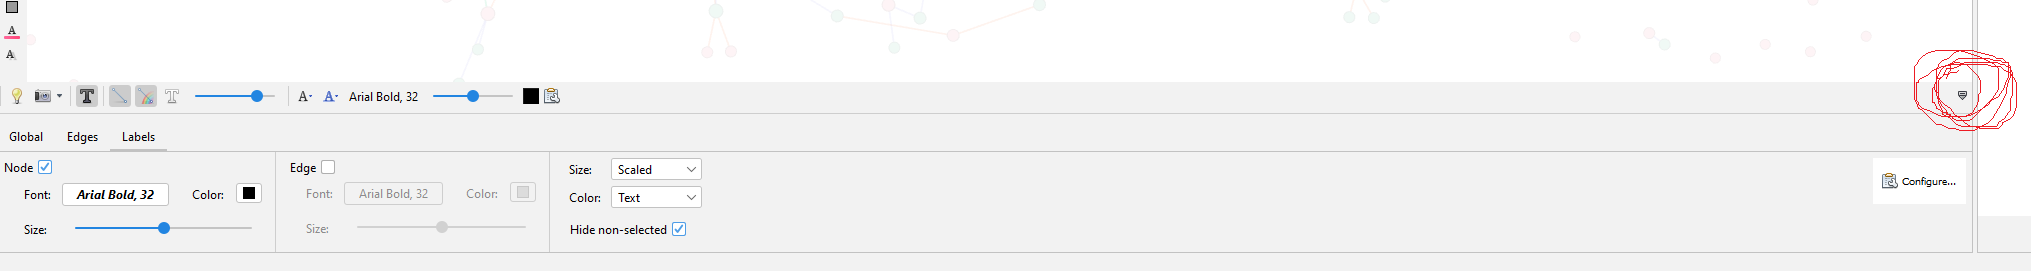

opmerkingen: in het 'preview'-blad van Gephi (naast Overview en Data laboratory) kunnen ook heel erg veel van deze en andere zaken aangepast worden in de visualisatie. Hier hebben we slechts enkele van de belangrijkste functies vanuit het 'overview'-menu voor deze visualisatie toegelicht.

**Importeren nieuw bestand met nodes of edges**

Als je later toch de data van de nodes of edges wil aanpassen in de originele spreadsheets, kun je de aangepaste versies eenvoudig opnieuw downloaden vanuit Excel of Google Spreadsheets en inladen via 'Data Laboratory'-'import spreadsheet' in Gephi. Je kan daarvoor eerst alle nodes of edges selecteren (ctrl+a) in Gephi en dan verwijderen. Vervolgens kun je de nieuwe set selecteren en inladen, zoals je deed na de opstart van Gephi.

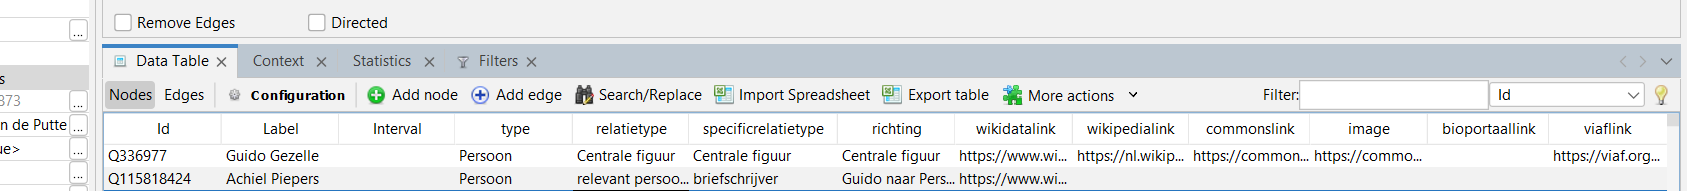

##GEPHI: VISUALISATIE 3B: PROJECTIEMAP



De tweede visualisatie die we willen uitwerken, is een herwerking van de vorige visualisatie. Er moeten dus geen nieuwe queries of data construeerd en toegevoegd worden.



In de volgende stap willen we dit bipartiet netwerk (een netwerk met twee soorten knopen, nl. instituten en personen) omzetten in een netwerk met slechts één soort knopen, namelijk enkel personen. Door een projectie kan de directe relatie van de personen gemeten worden op vlak van instituties. Hiervoor zal gebruik gemaakt worden van de plugin 'Multimode Projections'. Ook de werking daarvan lichten we kort toe.

Navigeer eerst naar 'tools' in het hoofdmenu (bovenaan). Daar kun je op 'plugin' klikken. Er opent dan een menu waar je plugins kunt downloaden en activeren.

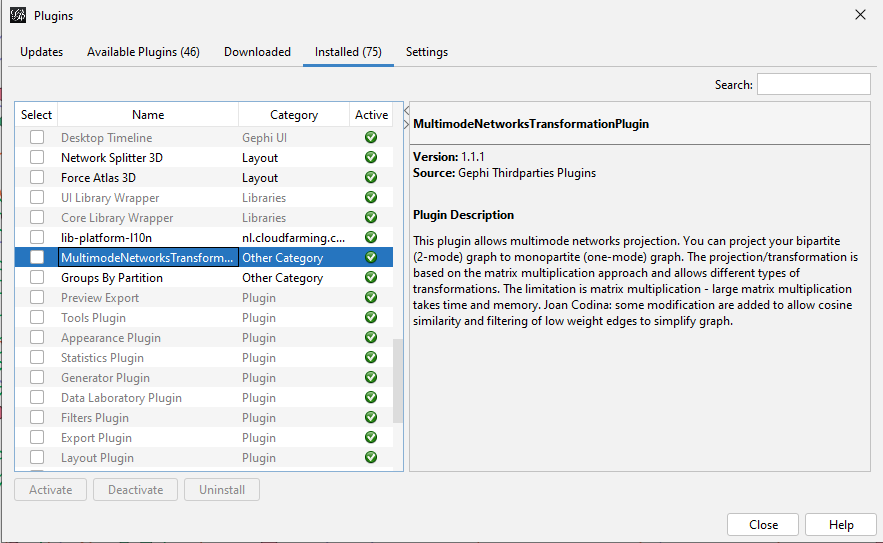

Eens je de plugin hebt geïnstalleerd en geactiveerd, moet je Gephi herstarten. Daarna kun je in het window-menu kiezen voor 'multimode projections'. Dat opent aan de rechterkant een scherm waarin je de projectie kunt doorvoeren.

Eerst laad je de attributen door op de knop te drukken en te kiezen voor 'type'. Vervolgens kan je left en right matrix instellen als 'persoon-instuut' en 'instituut-persoon'. Dit is logisch: personen zijn momenteel aan  instituten gelinkt, en vervolgens linken deze instituten door naar de volgende persoon. Door ketens van persoon - instituut - persoon te verbinden, kunnen we de directe link van persoon-persoon maken. Dit zal ervoor zorgen dat de knopen van instituut verdwijnen en erg veel verbindingen tussen personen in de plaats komen. Het is ook belangrijk om de vakjes om de edges en nodes te verwijderen. Op die manier zie je enkel nog de personen en de relaties tussen personen.  De dikte van de verbinding geeft dan het aantal gemeenschappelijke verenigingen weer.

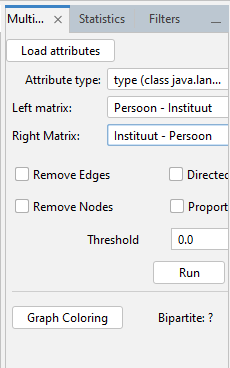

Als alles goed ging, zie je een grafiek die er ongeveer zo uitziet:

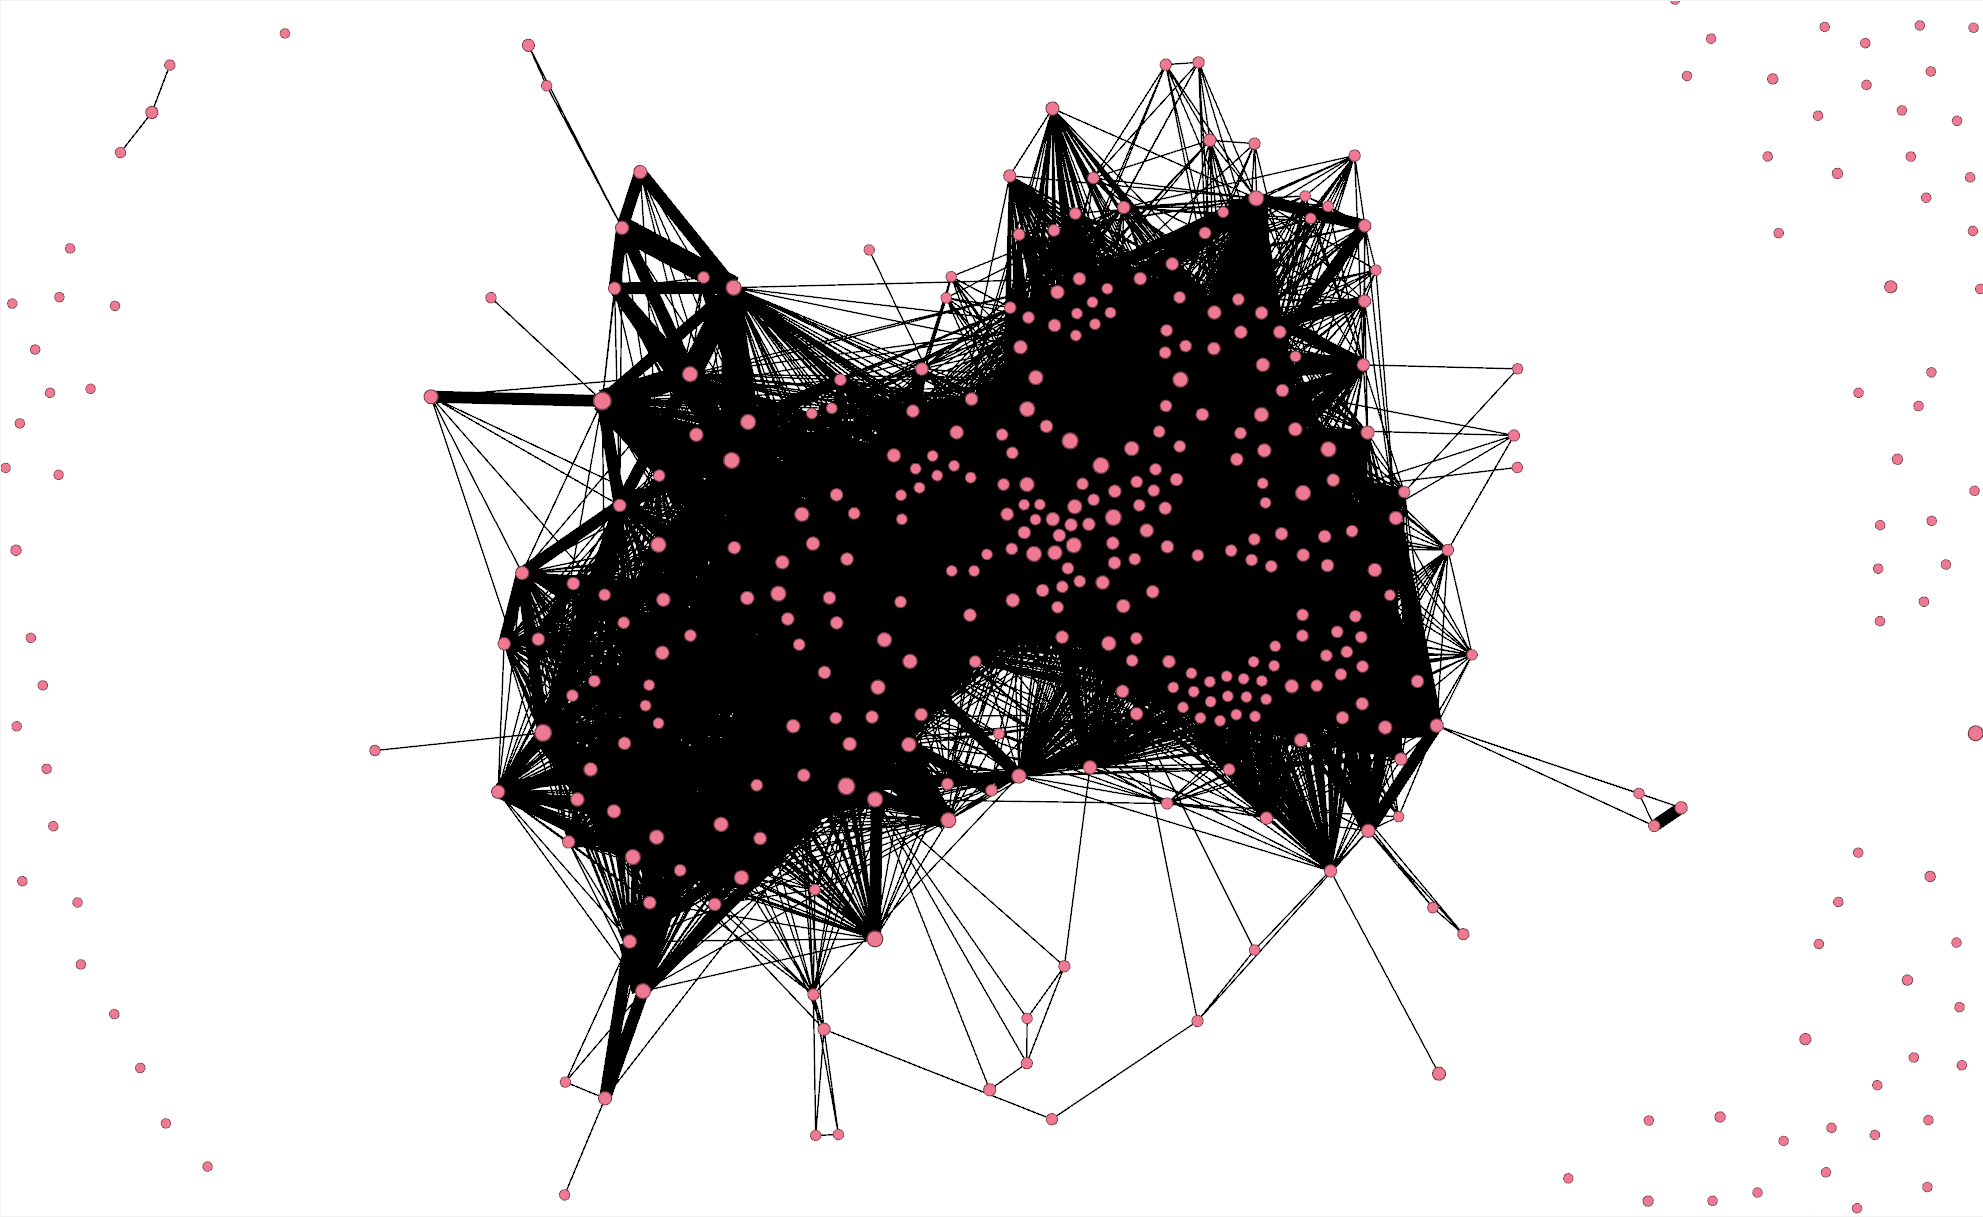

Het is normaal dat je erg veel lijnen/verbindingen ziet. Om de projectie van persoon-instituut naar persoon-persoon te maken, creeër je veel meer linken, omdat de instituten hierin weggecijferd worden. Om deze grafisch te verbeteren, kan je er nogmaals de forceAtlas2 algoritme op loslaten. Vervolgens kan je de grootte van de knopen aanpassen in het 'appearance'-scherm op basis van de nieuwe 'degree' (het aantal verbindingen). Daarnaast kan daarna opnieuw geordend worden.

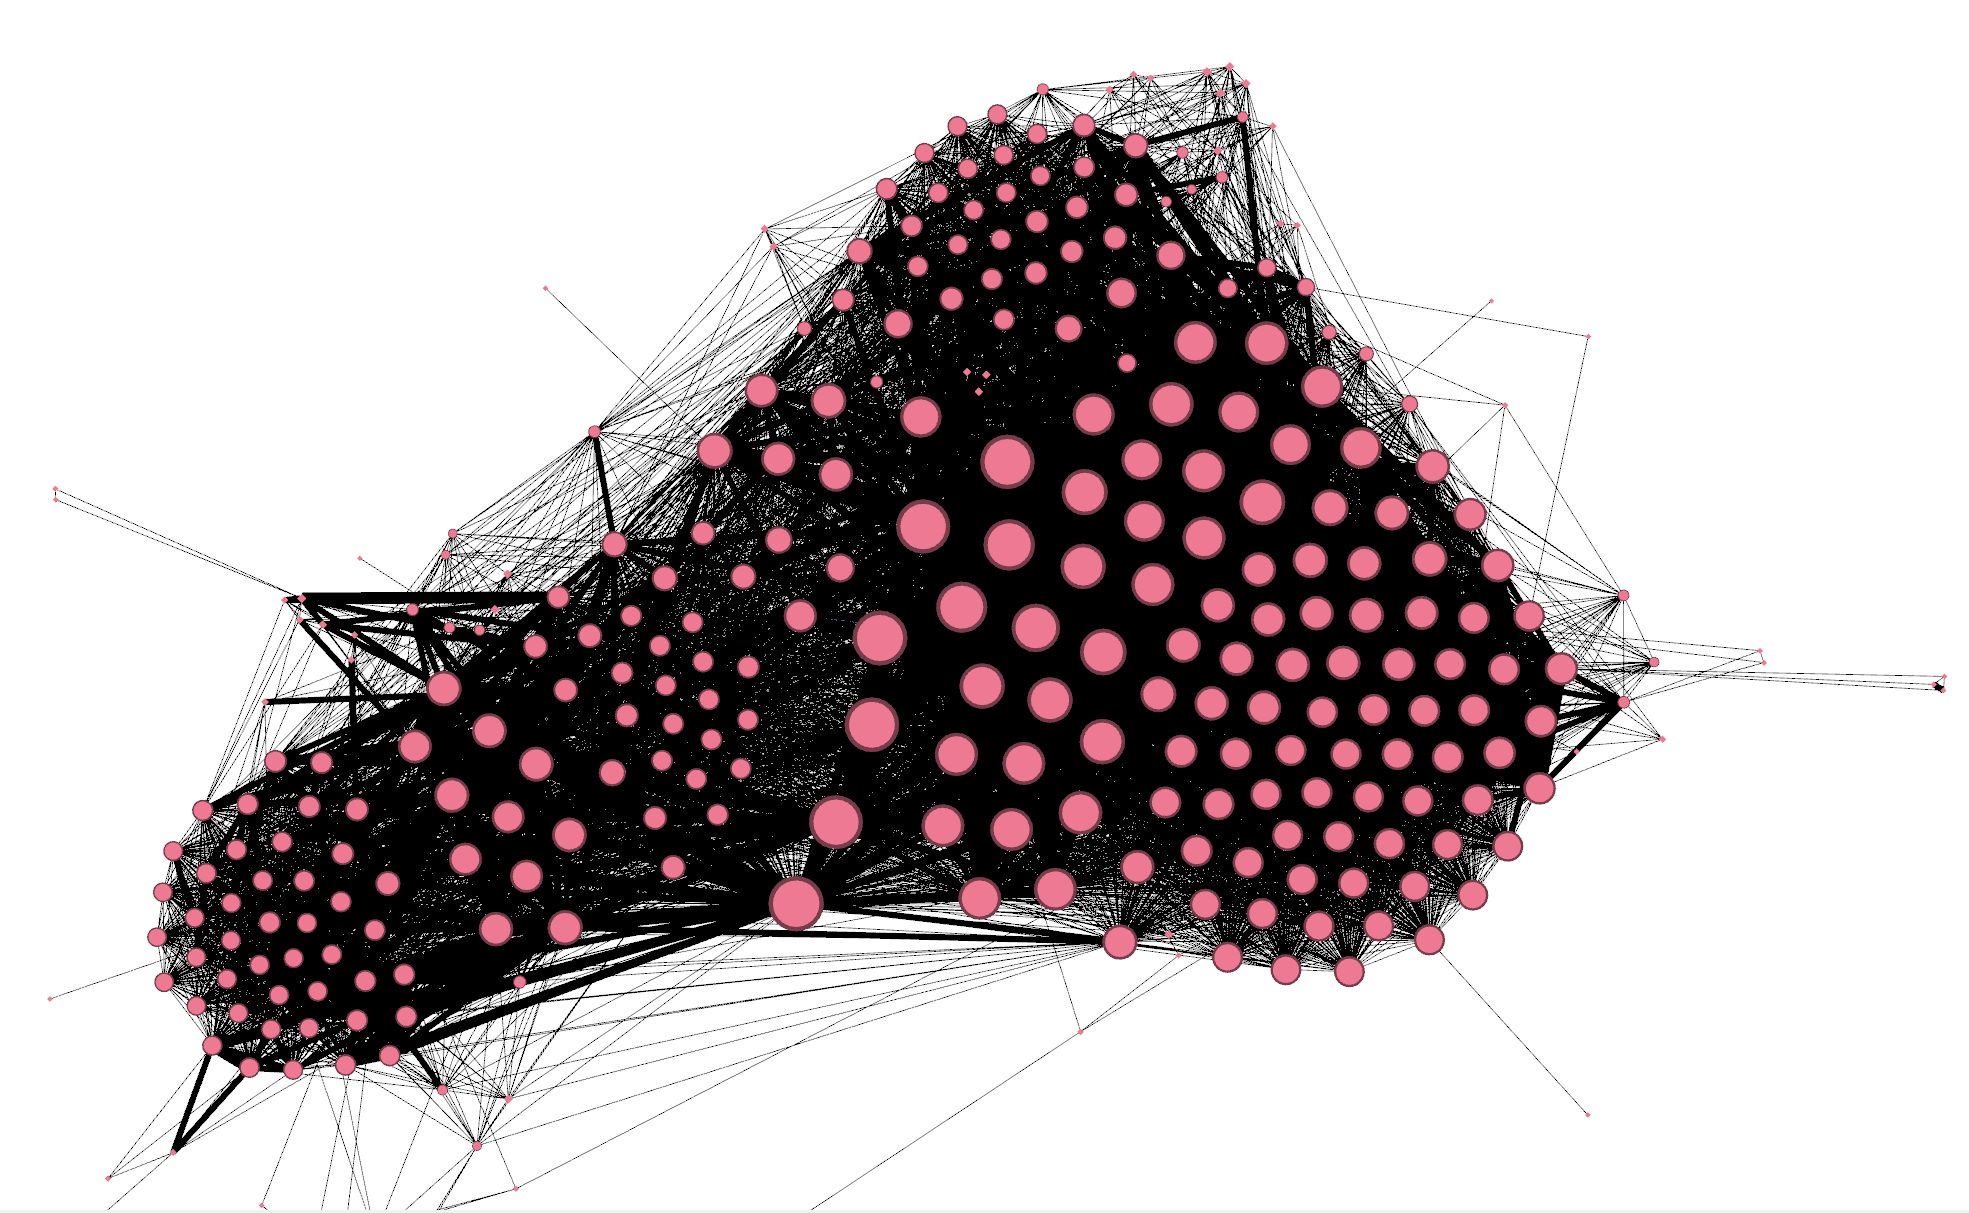

Tot slot willen we nu de projectie voltooid is, de sociale cohesie proberen meten en visualiseren: welke personen zijn meer met elkaar verbonden? zijn er specifieke groepen te meten?. Een handige tool daarvoor, is het berekenen van de Modularity Class. Op die manier zullen personen die meer met elkaar verbonden zijn, in eenzelfde groep worden toegewezen.

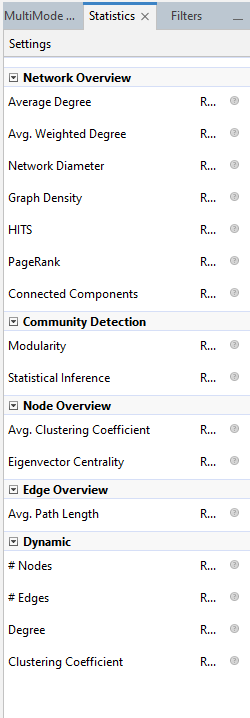

Vervolgens kunnen we in het 'appearance'-menu de instellingen aanpassen, zodat de kleur van de node gelinkt wordt aan deze modularity class. Als we vervolgens op 'apply' drukken, krijgen we onderstaande visualisatie.

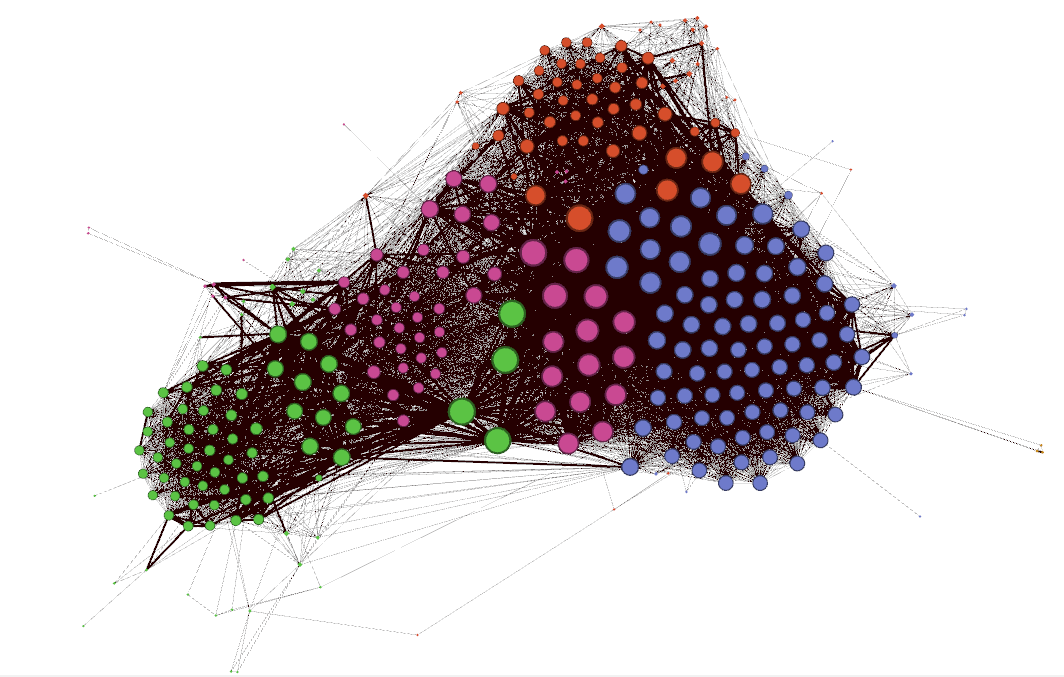

Opmerking: hoe kom je nu te weten welke personen om welke reden tot een van de clusters horen? Daarvoor is het nodig om de data te analyseren. Het beste kan gekeken worden naar verschillende personen binnen een bepaalde groep en kijken welke factoren een overlap tonen. Ook kan het interssant zijn via deze visualisatie te weten te komen wie overbruggend is tussen verschillende groepen.

Bron: http://social-dynamics.org/projecting-bipartite-network-gephi/

##EXPORT SIGMA: VISUALISATIE A

Nu enkele aanpassingen zijn gebeurd qua layout via Gephi, zullen we de visualisatie exporteren en klaarmaken om op interactieve manier online te plaatsen. In dit geval zullen we gebruik maken van de plugin Sigma. Deze is geintegreerd in Gephi en kan op eenvoudige wijze geactiveerd en gebruikt worden. Andere plugins kunnen gebruikt worden, of indien je wat kunt programmeren is html en java ook een oplossing. In een van de andere visualisaties (zie andere hoofdstukken) maken we een plugin/interface met behulp van Gemini 3.0.

Hier tonen we hoe je de plugin installeert. Daarna tonen we enkele simpele zaken die je tijdens de export kunt instellen. De procedure is net zoals de Multimode Plugin. Eerst ga je naar tools in het hoofdmenu (bovenaan), daarna klik je op plugin. In de interface zoek je naar Sigma Exporter. Je installeert die en drukt op 'active'. Eens geactiveerd, moet je Gephi herstarten om de plugin te laten werken. Na heropstart kan je je project exporteren.

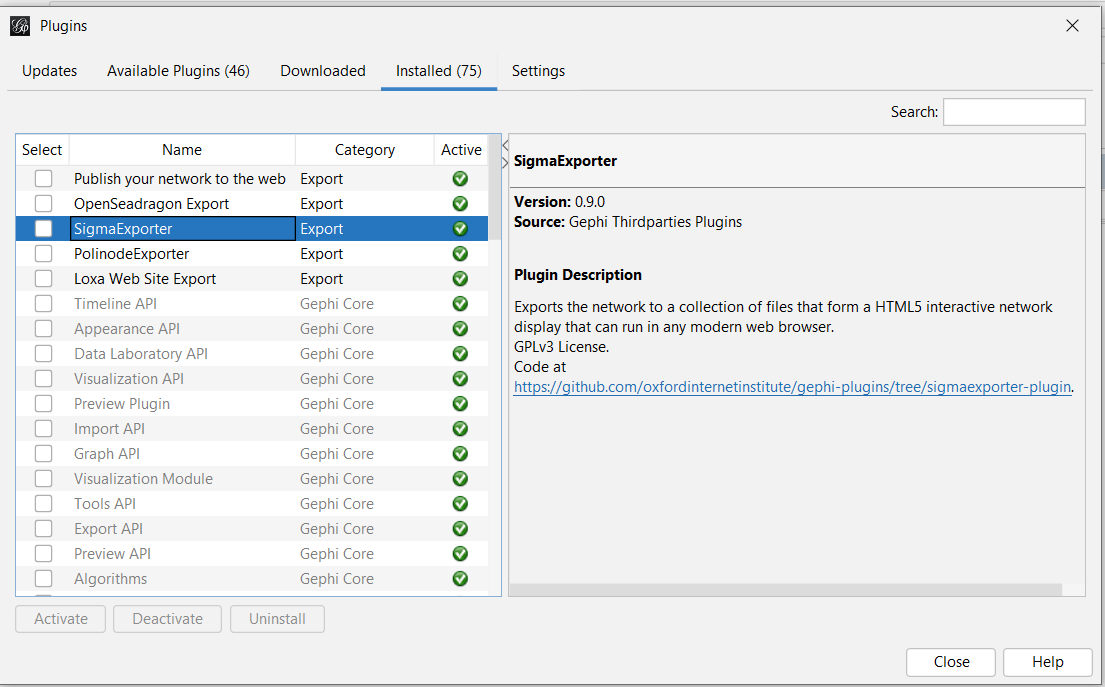

Er kan uitleg geplaatst worden bij de nodes en edges. Hier geven we aan dat node voor persoon staat. We geven ook aan dat een edge naar correspondentie of familie kan verwijzen. In de korte beschrijving kan meer uitleg geplaatst worden.Deze is beperkt door de ruimte die ze onmiddellijk inneemt op het scherm.

Er kan ook een uitvoerige uitleg bijgevoegd worden. Deze wordt zichtbaar in een popup-venster, waardoor de lengte veel meer kan zijn en niet in strijd komt met het zichtbare netwerk en de rest van de interface.

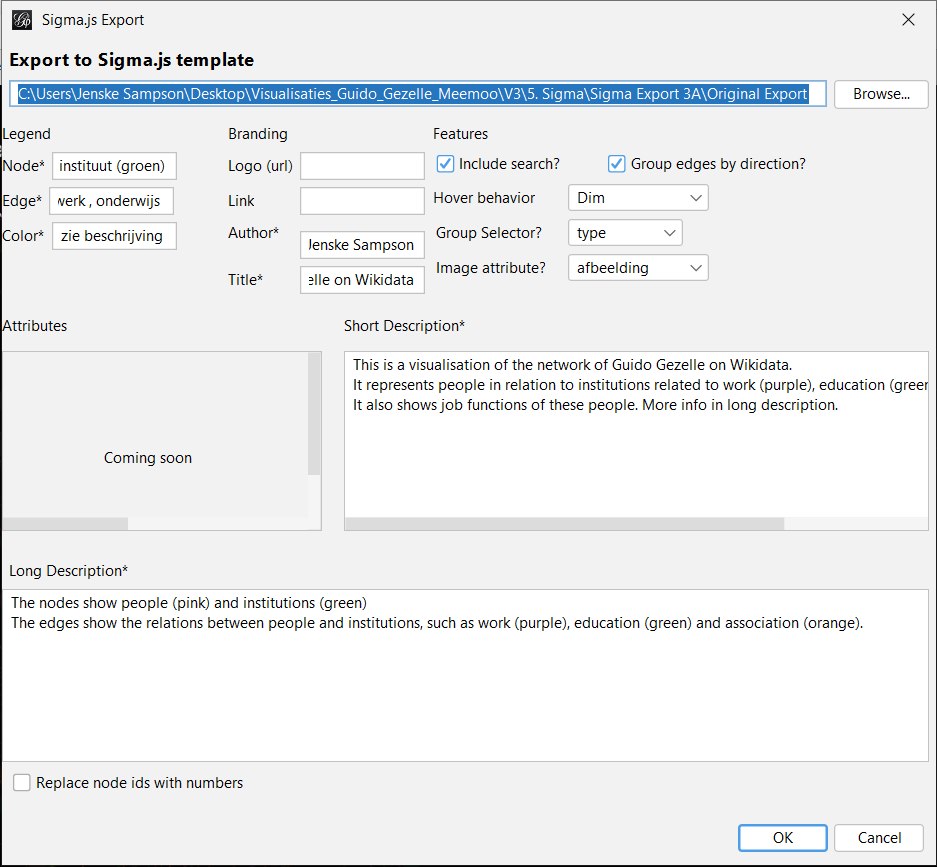

Er kan uitleg geplaatst worden bij de nodes en edges. Hier geven we aan dat node een 'persoon' representeert. In de korte beschrijving kan meer uitleg geplaatst worden. Deze is beperkt door de ruimte die ze onmiddellijk inneemt op het scherm. Een interessante functie die ingesteld kan worden is de 'group selector'. Hier kan een indeling op basis van een attribuut gemaakt worden. In dit geval kiezen we voor het specifieke type van de persoon, bv relevant persoon, vertaler, broer of zus, familielid, enzovoort. Sigma kan ook een foto linken en tonen per knoop. Hiervoor linken we de kolom imagelink aan 'image attribute'. Tot slot kan er ook een uitvoerige uitleg bijgevoegd worden. Deze wordt zichtbaar in een popup-venster, waardoor de lengte veel meer kan zijn en niet in strijd komt met het zichtbare netwerk en de rest van de interface.

Eens we de visualisatie opladen via Github (zie verder), zal dit er ongeveer zo uitzien:

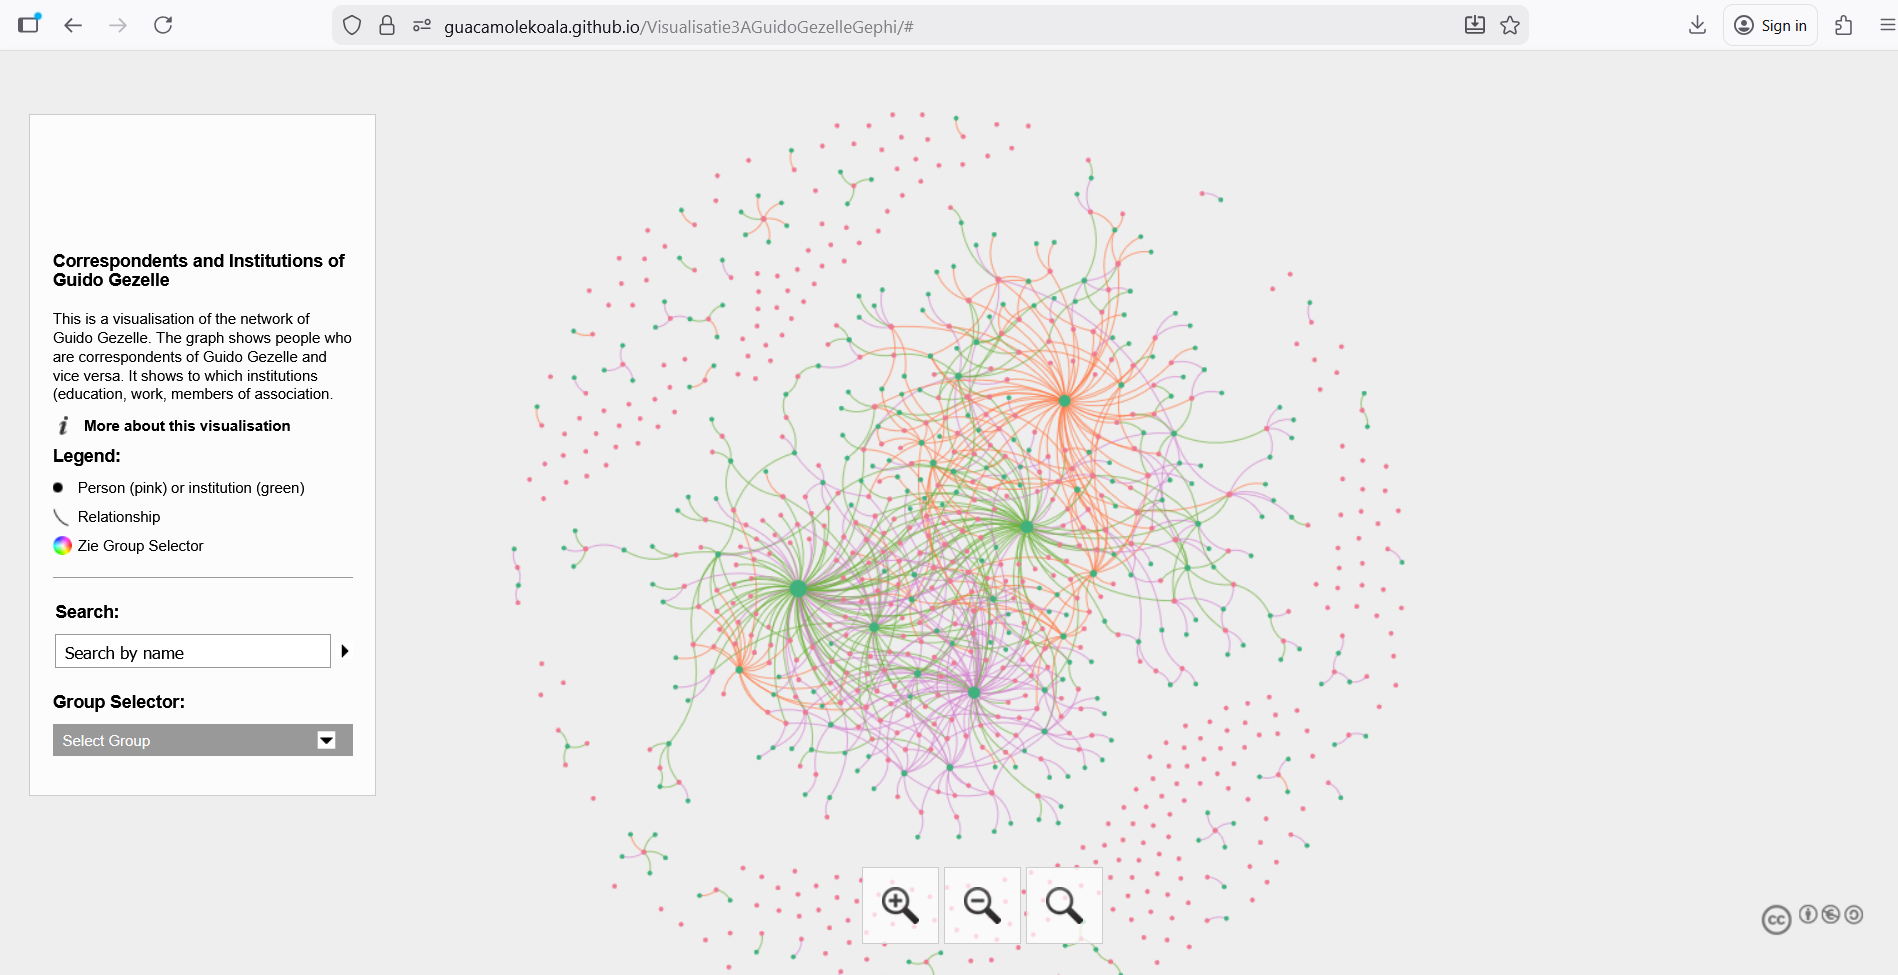

als we op een knoop klikken zien we:

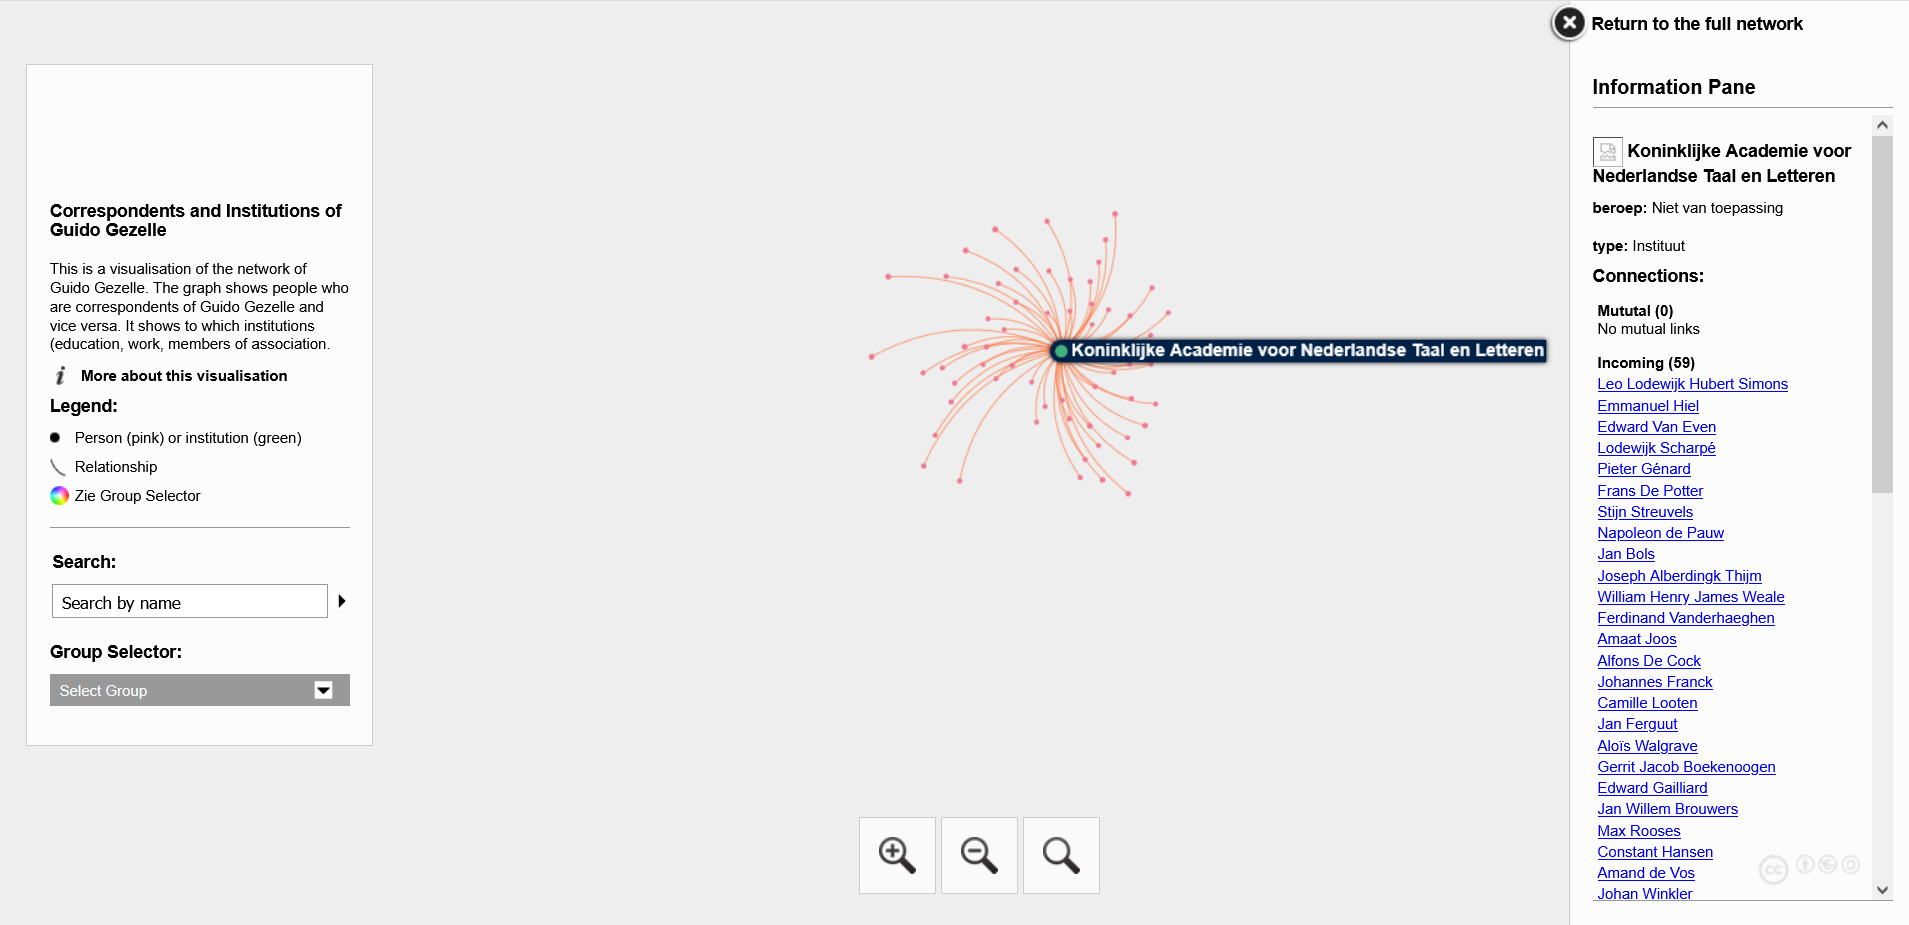

##EXPORT SIGMA: VISUALISATIE B

We doorlopen dezelfde procedure voor visualisatie B, maar slaan op een andere locatie op en vullen een andere beschrijving en dergelijke meer.

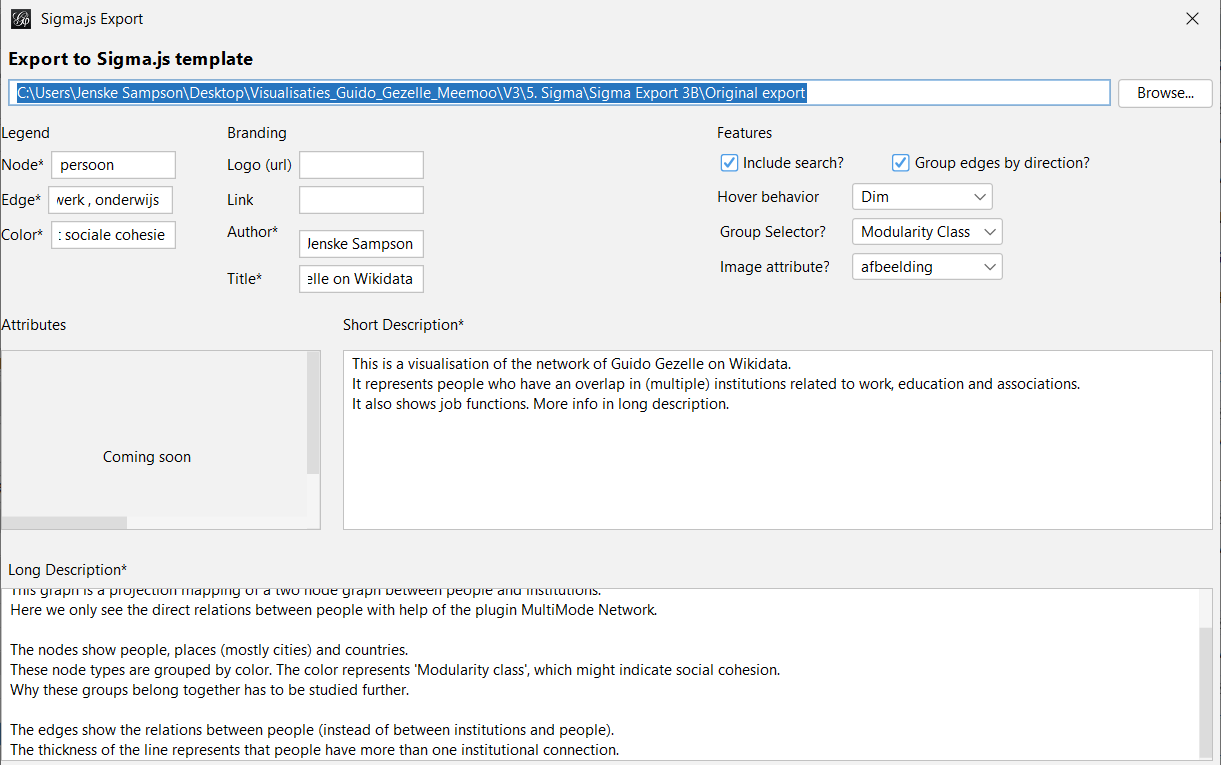

opmerking: in het export-menu van Sigma kan gemakkelijk een bestandslocatie gekozen worden. Na het uitvoeren van de export kan je op die locatie een map onder de naam 'network' vinden. Hierin zitten alle bestanden om de visualisatie op te laden als een website met enkele interactieve aspecten.Eigenlijk is de visualisatie nu zo goed als klaar. Vanaf hier kan je de visualisatie opladen op github.  

Eigenlijk is de visualisatie nu zo goed als klaar. Vanaf hier kan je de visualisatie opladen op github. Na opladen zal deze er ongeveer zo uitzien.

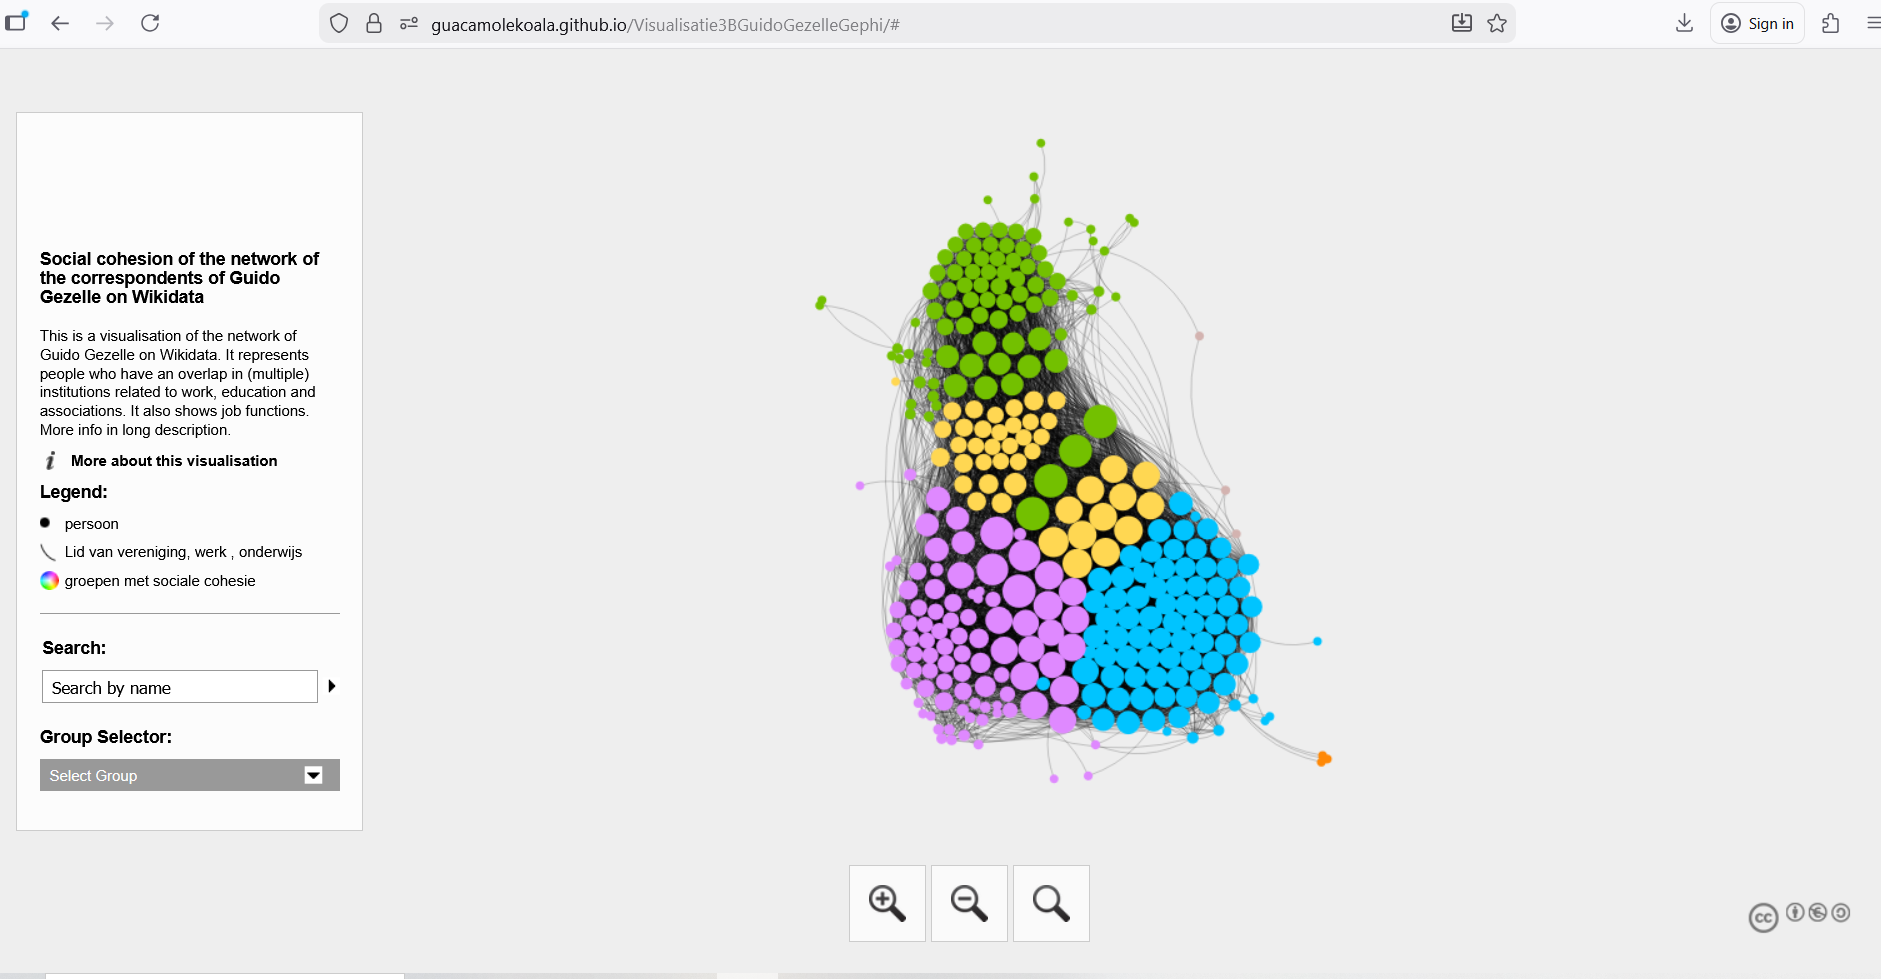

## UPLOAD GITHUB

Vervolgens willen we deze visualisatie interactief kunnen aanbieden op een website. Via github kunnen we deze documenten opladen en omzetten in een webpagina. Op zich is dit niet erg moeilijk eens men een account heeft op Github. Eerst en vooral moet er een repository gemaakt worden. Dit repository kan vervolgens omgezet worden tot een Github-page. Via de link naar de page krijg je de visualisatie te zien.

**repository**

Eerst en vooral maak je dus een nieuw repository aan op Github. Geef het een toepasselijke naam, bv 'VisualisatieGezelle1'. Vervolgens wordt de map met bestanden die werd klaargemaakt door Sigma hierin opgeladen.
Opmerking: het is belangrijk de inhoud van de map 'network' te kopiëren. De map 'network' zelf wordt niet mee gekopieerd. in dit geval zijn dit ongeveer 33 bestanden.

Klik op 'add files/upload new files'. Dit lukt mogelijk enkel in Chrome. Sommige browsers nemen niet alle bestanden over. Eens het opladen klaar is, kan je op 'commit' drukken. De bestanden zitten nu in het repository

**Github page**

nu zullen we van het repository een webpagina maken. Daarvoor klikken we op het 'repository' en gaan vervolgens naar de 'settings'. Daar kiezen we voor 'pages'. Onder 'build and deployment' selecteer je 'main' als branch en in het vak ernaast voor 'root'. Klik vervolgens op 'save'. Wacht enkele minuten en herlaad de pagina. Je zult nu een link te zien krijgen waarop de webpagina te bekijken is:

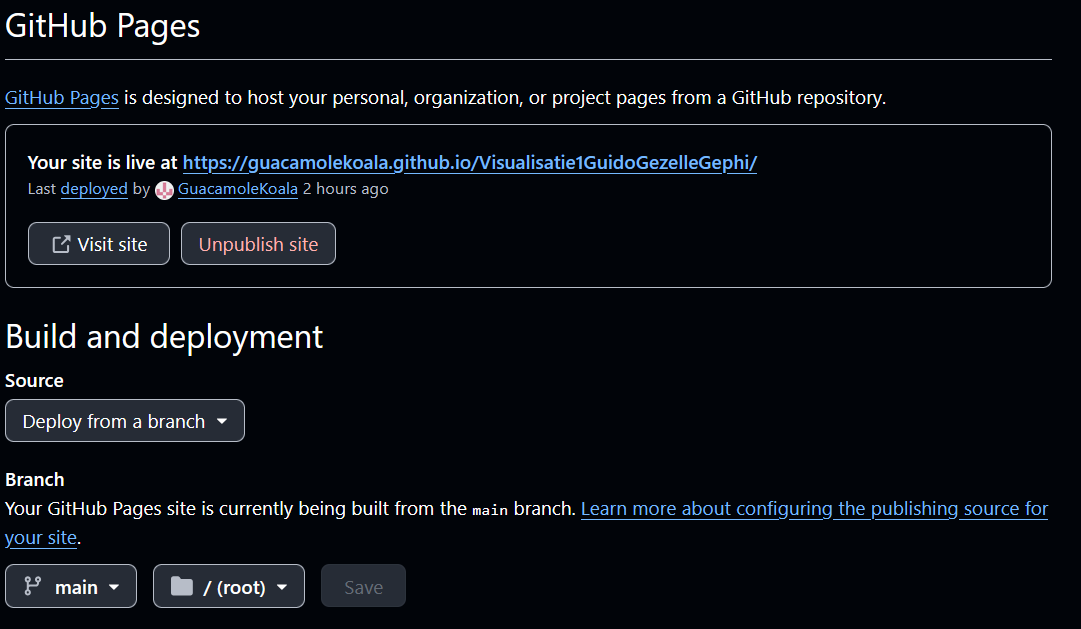

**Version control**

Je kan de code die opgeladen is, ook makkelijk aanpassen via het platform via Github. Op die manier kan je ook een controle/geschiedenis opbouwen aan veranderingen in je code. Op die manier kan je ook terugkeren naar een eerder moment, moest er iets fout lopen.

Opmerking:
Op elk moment kan de dataset aangepast worden door op github naar het bestand 'data.json' te gaan en dit te vervangen door een nieuwe export vanuit Gephi (of elders).
De titel, korte en uitgebreide beschrijving, enzovoort kunnen eenvoudig aangepast worden in het config.json of index.html via Github of een andere editor.
Ook de algemene werking van de interface kan aangepast worden via het main.js- bestand. Ook dit kan vervangen worden of aangevuld worden waar nodig met nieuwe code.

**Code aanpassen op Github:**



Je kan code van de bestanden gemakkelijk aanpassen via Github. Ga daarvoor naar de repository die je eerder hebt gemaakt en bekijk de bestanden door erop te klikken.

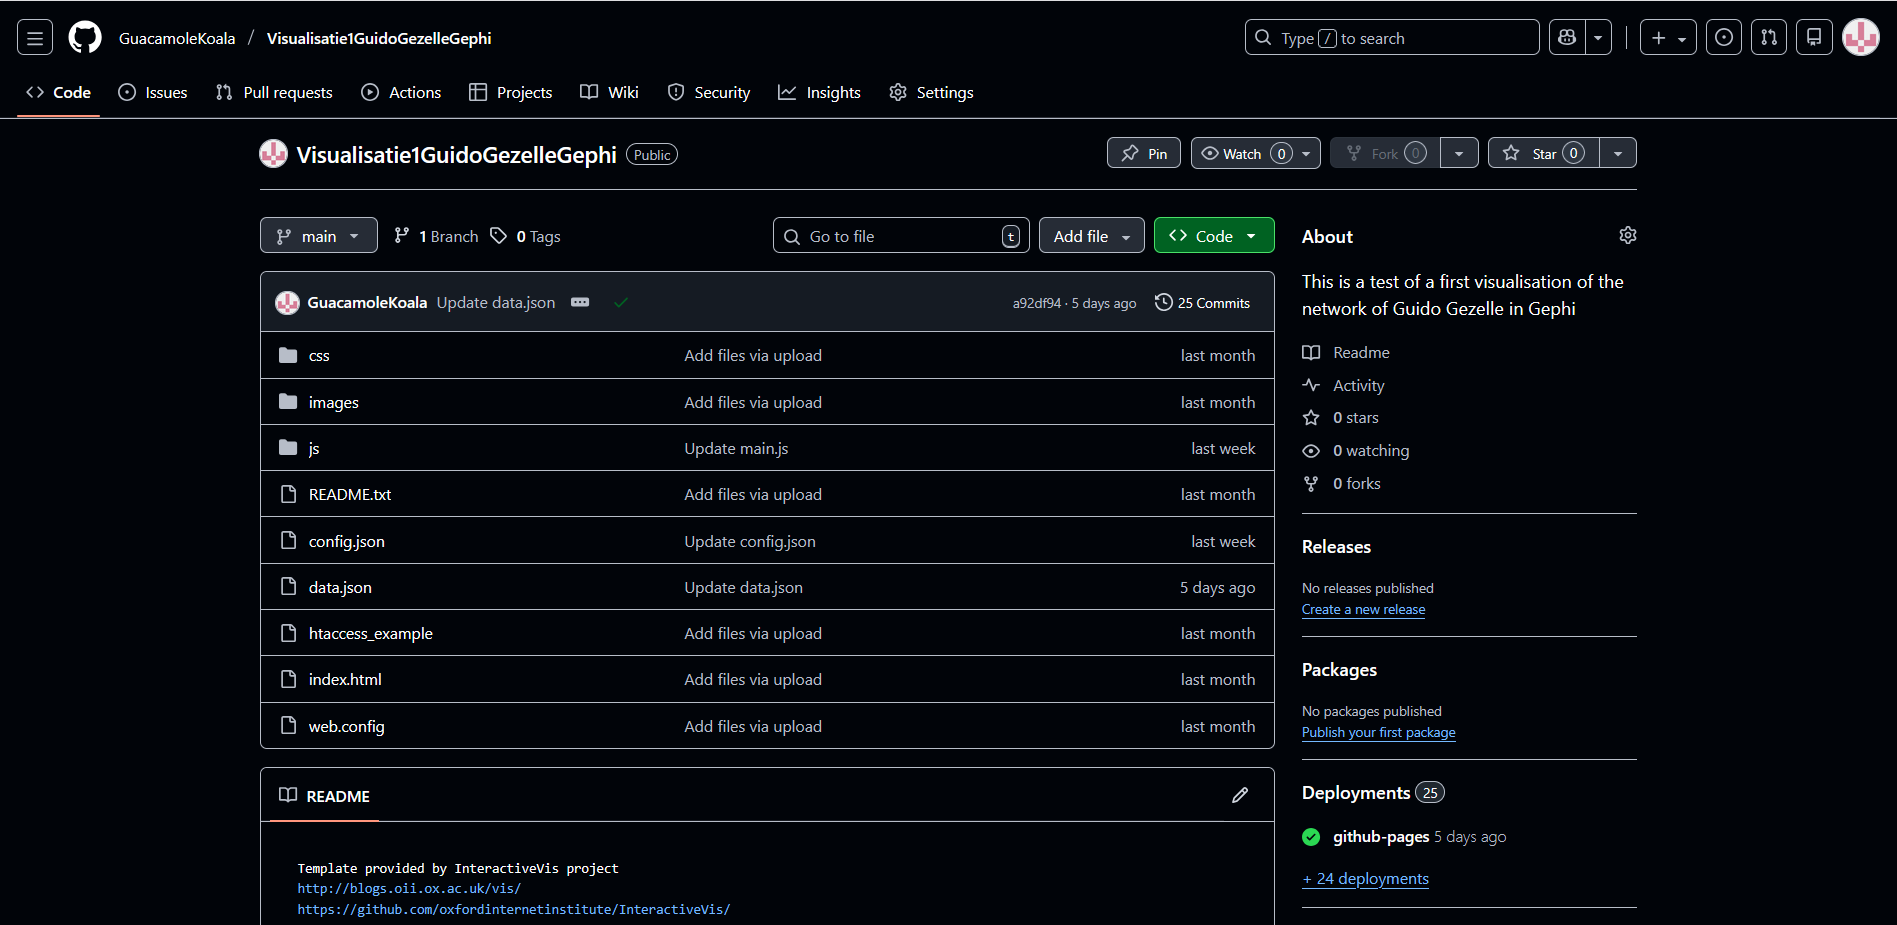

Als je rechts op het potlood-icoontje klikt, kun je de code direct aanpassen.

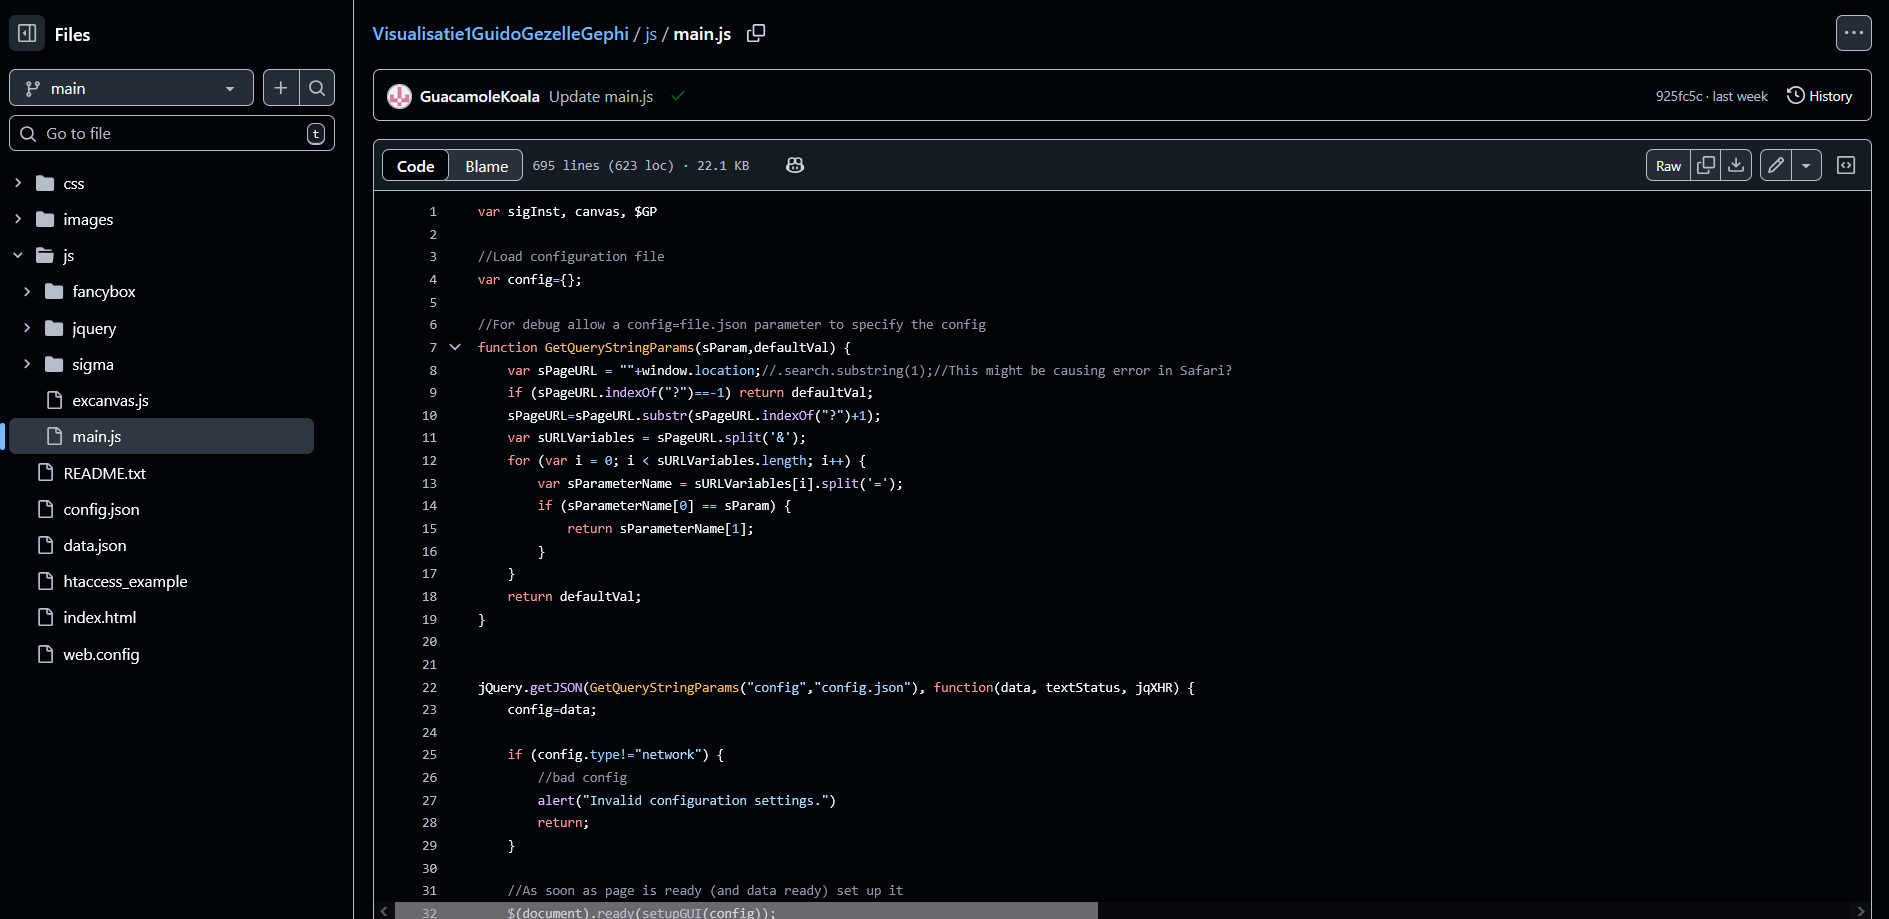

Na de aanpassingen druk je op 'commit changes'. Hier kun je ook een nota toevoegen van wat je precies hebt gedaan of verbeterd. Dit is belangrijk voor de controle van versies, indien er iets misgaat bijvoorbeeld.

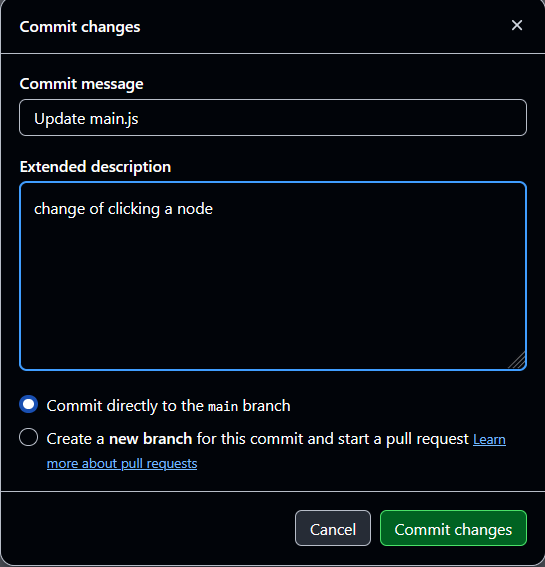

Na een paar minuten kun je de aanpassingen zien op de webpagina. Soms moet je opletten dat de browser niet een oude versie blijft herladen (door cache of cookies). Een optie is om even te wachten of in tussentijd een andere browser te proberen.

##AANPASSEN SCRIPT: VISUALISATIE 3A

Nu de pagina opgeladen is als interactieve webpagina, kunnen we nog een paar laatste details aanpassen. Dit is mogelijk het meeste technische gedeelte van deze handleiding. De bedoeling is om de code die door Sigma gegenereerd werd om de interface wat om te vormen. Zo wordt informatie beter weergegeven en is interactie eenvoudiger.

Bij visualisatie 3a willen we graag de volgende zaken aanpassen na de Sigma-export. Ook hier zullen we de code daarvoor aanpassen van verschillende bestanden. 1)we zullen het paneel aan de rechterkant 'information pane' in plaats van 'information panel'. 2)Daarnaast willen we ook dat type en beroep in deze volgorde onder elkaar worden weergegeven wanneer er op een knoop wordt geklikt. 3) momenteel is de afbeelding nog wat groot soms in het rechtermenu. Dat willen we kunnen oplossen.4) evt willen we nog meer informatie laten zien zoals een link naar de afbeelding en een link naar het wikidata item van de knoop. 5) in de group-selector willen we namen kunnen geven aan de groepen, in dit geval persoon of instituut, 6) tot slot willen we de inkomende/uitgaande verbindingen op andere wijze opdelen, namelijk op vlak van werkgever, associatie en onderwijsinstelling.



Door gebrek aan technische kennis om goed te kunnen programmeren, hebben we ook de hulp van Gemini 2.5 en 3.0 gevraagd. Op die manier zijn we aan de slag gegaan met de bestanden uit de Sigma-export. Een nuttige tip is om elk van deze problemen afzonderlijk en stap voor stap op te lossen door goede prompts op te stellen. Hierbij vervang je bestand na bestand en ga je iedere stap na of de visualisatie nog werkt. Aangezien het ook mogelijk is bestanden door te sturen in Gemini, hebben we de config.json, index.html, data.json en main.js laten analyseren. Door aanpassingen te maken in deze vier bestanden zijn alle problemen hierboven aangepast. Dat kan in Github zelf, door op de bestanden in de repository te klikken en vervolgens te bewerken. Door deze veranderingen te 'committen', voer je de aanpassingen door. Zo heb je een controle van verschillende versies indien er iets misgaat. Je kan ook beslissen om de aanpassingen via Notepad door te voeren en later op Github op te laden.

**1. Correctie fout in 'information panel'**: het eerste probleem is simpel op te lossen door in de index.html te zoeken naar 'information pane' en deze simpelweg aan te passen naar 'information panel'. Vervolgens kun je het bestanden opnieuw opladen.

**2. extra informatie en volgorde informatie van knopen**: In het aangepaste main.js-bestand is de code vervangen door een structuur die expliciet de prioriteit en volgorde van de gewenste attributen definieert. Hiervoor werd geprompt met Gemini 3.0

Bestand: mainadj.js Functie: nodeActive(a)

Zoek in de functie nodeActive naar de sectie waar de node-attributen worden verwerkt (rond regel 289 in de originele code) en vervang de gehele if (f.attributes)-blok. JavaScript

```
// OUDE CODE (in main.js)
if (f.attributes) {
    var image_attribute = false;
    if (config.informationPanel.imageAttribute) {
        image_attribute=config.informationPanel.imageAttribute;
    }
    e = [];
    temp_array = [];
    g = 0;
    for (var attr in f.attributes) {
        var d = f.attributes[attr],
            h = "";
        if (attr!=image_attribute) {
            h = '<span><strong>' + attr + ':</strong> ' + d + '</span><br/>'
        }
        //temp_array.push(f.attributes[g].attr);
        e.push(h)
    }

    if (image_attribute) {
        //image_index = jQuery.inArray(image_attribute, temp_array);
        $GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
    } else {
        $GP.info_name.html("<div><span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
    }
    // Image field for attribute pane
    $GP.info_data.html(e.join("<br/>"))
}

```

Nieuwe Code (vervangende logica)

Plaats deze code in plaats van het bovenstaande blok in nodeActive(a): JavaScript



```
// NIEUWE CODE (in mainadj.js)
if (f.attributes) {
        var image_attribute = false;
        if (config.informationPanel.imageAttribute) {
            image_attribute=config.informationPanel.imageAttribute;
        }

        var e = []; // Array voor de attribute display HTML-fragmenten
        var addedAttributes = {}; // Houd bij welke attributen al zijn toegevoegd
        
        // 1. Definieer de gewenste volgorde
        var priorityOrder = ['type', 'beroep', 'Modularity Class'];
        
        // 2. Voeg de geprioriteerde attributen toe in de gedefinieerde volgorde
        for (var i = 0; i < priorityOrder.length; i++) {
            var attrKey = priorityOrder[i];
            
            // Controleer of het attribuut bestaat in de data en niet het afbeelding-attribuut is
            if (f.attributes[attrKey] !== undefined && attrKey !== image_attribute) {
                var d = f.attributes[attrKey];
                
                // Maak de HTML string
                var h = '<span><strong>' + attrKey + ':</strong> ' + d + '</span>';
                
                e.push(h);
                addedAttributes[attrKey] = true;
            }
        }
        
        // 3. Voeg de overige attributen toe (alleen degenen die nog niet zijn toegevoegd en niet de afbeelding)
        for (var attr in f.attributes) {
            var d = f.attributes[attr];
            
            if (!addedAttributes[attr] && attr !== image_attribute) {
                var h = '<span><strong>' + attr + ':</strong> ' + d + '</span>';
                e.push(h);
            }
        }

        if (image_attribute) {
            //image_index = jQuery.inArray(image_attribute, temp_array);
            $GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        } else {
            $GP.info_name.html("<div><span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        }
        // Image field for attribute pane
        $GP.info_data.html(e.join("<br/>"))
    }
```





**3. Grootte van de afbeelding aanpassen**: Ook hier werd hulp gevraagd aan Gemini. De grootte van de afbeelding wordt bepaald door de HTML-styling binnen de nodeActive functie in mainadj.js. We kunnen dit aanpassen door een vaste maximale hoogte of breedte in te stellen op de <img> tag. Hier is de aangepaste code die een maximale hoogte van 60 pixels instelt voor de afbeelding, waardoor deze als een thumbnail wordt weergegeven.

Zoek de regel in de sectie waar image_attribute waar is (if (image_attribute)) in mainadj.js:

JavaScript
```
// OUDE CODE (in mainadj.js - binnen if (image_attribute))
$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
```

Nieuwe Code (met vaste afmeting)

Vervang de style attribuutwaarde om een maximale hoogte in te stellen (bijvoorbeeld max-height:60px en max-width:60px om een duidelijke thumbnail te krijgen):

JavaScript:
```
// NIEUWE CODE (vervangende regel in mainadj.js)
$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle; max-height:60px; max-width:60px; margin-right: 10px;\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
```

**4. toevoegen van image link en wikidata link**:

U moet het volledige if (f.attributes)-blok binnen de functie nodeActive(a) van uw bestand mainadj.js vervangen.

Code om te Verwijderen (in mainadj.js)

Zoek in de functie nodeActive(a) naar het volledige if (f.attributes) blok en verwijder het. De code ziet er ongeveer zo uit (afhankelijk van eerdere aanpassingen):
JavaScript



```
// Start van de code die u moet vervangen/verwijderen:
if (f.attributes) {
    var image_attribute = false;
    if (config.informationPanel.imageAttribute) {
        image_attribute=config.informationPanel.imageAttribute;
    }
    // ... hier staat de oude logica voor het verwerken van attributen,
    // de naam en het tonen van de afbeelding (mogelijk al deels aangepast)
    // ...
    // De laatste regel binnen deze if-blok is waarschijnlijk:
    $GP.info_data.html(e.join("<br/>"))
}
```
Nieuwe Code om te Plakken

Plak in plaats van het verwijderde blok de volgende code. Dit combineert:
Volgorde: type, beroep, Modularity Class eerst. Thumbnail: max-height:60px; max-width:60px; voor de afbeelding. Links: Wikidata-link (via b.id) en de Afbeelding URL.

JavaScript

```
if (f.attributes) {
  		var image_attribute = false;
  		if (config.informationPanel.imageAttribute) {
  			image_attribute=config.informationPanel.imageAttribute;
  		}

        var e = []; // Array voor de attribute display HTML-fragmenten
        var addedAttributes = {}; // Houd bij welke attributen al zijn toegevoegd
        
        // 1. Definieer de gewenste volgorde
        var priorityOrder = ['type', 'beroep', 'Modularity Class'];
        
        // 2. Voeg de geprioriteerde attributen toe in de gedefinieerde volgorde
        for (var i = 0; i < priorityOrder.length; i++) {
            var attrKey = priorityOrder[i];
            
            // Controleer of het attribuut bestaat in de data en niet het afbeelding-attribuut is
            if (f.attributes[attrKey] !== undefined && attrKey !== image_attribute) {
                var d = f.attributes[attrKey];
                
                // Maak de HTML string
                var h = '<span><strong>' + attrKey + ':</strong> ' + d + '</span>';
                
                e.push(h);
                addedAttributes[attrKey] = true;
            }
        }
        
        // 3. Voeg de overige attributen toe
        for (var attr in f.attributes) {
            var d = f.attributes[attr];
            
            if (!addedAttributes[attr] && attr !== image_attribute) {
                var h = '<span><strong>' + attr + ':</strong> ' + d + '</span>';
                e.push(h);
            }
        }

        // --- NIEUWE LOGICA VOOR LINKS ---
        
        // 4. Voeg de Wikidata link toe (gebruikt de node ID als Q-ID)
        var qid = b.id;
        // We gaan ervan uit dat de node ID (b.id) de Q-ID is, en de link is naar de hoofdnaamruimte
        if (qid && qid.match(/^Q[0-9]+$/i)) {
            var wikidata_url = 'https://www.wikidata.org/wiki/' + qid;
            var wikidata_html = '<span><strong>Wikidata:</strong> <a href="' + wikidata_url + '" target="_blank">Bekijk item (' + qid + ')</a></span>';
            e.push(wikidata_html);
        }
        
        // 5. Voeg de Afbeelding URL link toe
        if (image_attribute && f.attributes[image_attribute]) {
            var image_url = f.attributes[image_attribute];
            var image_link_html = '<span><strong>Afbeelding URL:</strong> <a href="' + image_url + '" target="_blank">Directe link</a></span>';
            e.push(image_link_html);
        }

        // --- EINDE NIEUWE LOGICA ---

        // De thumbnail-weergave (reeds aangepast voor max-height/width)
        if (image_attribute) {
        	$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle; max-height:60px; max-width:60px; margin-right: 10px;\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        } else {
        	$GP.info_name.html("<div><span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        }
        
        // Geef alle attributen en links weer, gescheiden door <br/>
        $GP.info_data.html(e.join("<br/>"))
    }
```





**5. Groepenselector koppelen aan juiste namen**:

A. Configuratie Aanpassen (configadj.json)

Mogelijk staat de groepenselector ingesteld op het attribuut "beroep". Dit moet veranderd worden naar "type": in configadj.json kun je zoeken naar "groupSelectorAttribute": "beroep" en dit aanpassen naar	"groupSelectorAttribute": "type". Door dit te doen, verzamelt de visualisatie alle unieke waarden van het attribuut 'type' (Persoon, Instituut) en maakt hier groepen van.

B. JavaScript Aanpassen: De Groepslogica Zelf

In mainadjj.js bestand is de logica die de nodes in a.clusters verdeelt nog gebaseerd op de kleur van de node (b.color). Dit moet veranderen naar de waarde van het nieuwe attribuut (type).

Bestand: mainadjj.js (Functie initSigma, rond regel 108)

Oude Code (verwijderen)

JavaScript


```
a.iterNodes(
    function (b) { //This is where we populate the array used for the group select box

        // note: index may not be consistent for all nodes. Should calculate each time.  
        // alert(JSON.stringify(b.attr.attributes[5].val));
        // alert(b.x);
        a.clusters[b.color] || (a.clusters[b.color] = []);
        a.clusters[b.color].push(b.id);//SAH: push id not label
    }
);
```
Nieuwe Code (plakken)

Vervang het volledige a.iterNodes blok met deze nieuwe logica, die de groupSelectorAttribute uit de configuratie gebruikt:
JavaScript

```
var groupAttribute = config.features.groupSelectorAttribute;
a.iterNodes(
    function (b) { //This is where we populate the array used for the group select box
        // De groepssleutel is de waarde van het geconfigureerde attribuut, of de kleur als fallback (b.color)
        var groupKey = b.color;
        if (groupAttribute && b.attr.attributes && b.attr.attributes[groupAttribute]) {
             groupKey = b.attr.attributes[groupAttribute];
        }

        a.clusters[groupKey] || (a.clusters[groupKey] = []);
        a.clusters[groupKey].push(b.id);//SAH: push id not label
    }
);
```




**6. Inkomende/uitgaande verbindingen op andere wijze opdelen, namelijk op vlak van werkgever, associatie en onderwijsinstelling**

A. Group Selector Data: Functie initSigma(config)

Hier wordt de logica toegevoegd om de kleurcode te koppelen aan de leesbare groepsnaam (bijv. "Persoon"). Locatie: Binnen function initSigma(config) { ... }, specifiek in het blok dataReady = function() { ... } (rond regel 105-120).

OUDE CODE (VERWIJDEREN)

JavaScript


```
a.clusters = {};
a.iterNodes(
    function (b) {
        a.clusters[b.color] || (a.clusters[b.color] = []);
        a.clusters[b.color].push(b.id);
    }
);
```

NIEUWE CODE (VERVANG DOOR DIT)

JavaScript

```
a.clusters = {};
a.clusterNames = {}; // Object om kleur aan attribuutnaam te koppelen
var groupAttrKey = config.features.groupSelectorAttribute;
a.iterNodes(
    function (b) {
        // Groeperen blijft op kleur om de functionaliteit van de Sigma.js-kern te behouden
        a.clusters[b.color] || (a.clusters[b.color] = []);
        a.clusters[b.color].push(b.id);

        // ClusterNames vullen met de groepsnaam voor weergave in het keuzemenu
        var groupName = b.attr.attributes[groupAttrKey];
        if (groupName) {
            a.clusterNames[b.color] = groupName; // Map kleur aan groepsnaam
        }
    }
);
```

B. Group Selector HTML: Functie configSigmaElements(config)

Dit blok regelt de weergave van de namen in de uitklapbare lijst van de Group Selector. Locatie: Binnen function configSigmaElements(config) { ... } (rond regel 300-315). U vervangt de bestaande for loop die de HTML genereert.

OUDE CODE (VERWIJDEREN)

JavaScript

var a = [],
    b,x=1;
for (b in sigInst.clusters) a.push('<div style="line-height:12px"><a href="#' + b + '"><div style="width:40px;height:12px;border:1px solid #fff;background:' + b + ';display:inline-block"></div> Group (' + sigInst.clusters[b].length + ' members)</a></div>');
// De oude code kan iets afwijken, maar het is de loop die de <a> tags met de groepen maakt.

NIEUWE CODE (VERVANG DOOR DIT)

JavaScript

var a = [],
    b,x=1;
// MODIFIED: Gebruik sigInst.clusterNames om de naam van het attribuut weer te geven
for (b in sigInst.clusters) {
    // Gebruik de toegewezen naam, anders een fallback op basis van kleur
    var groupName = sigInst.clusterNames[b] || 'Groep ' + (x++);
    a.push('<div style="line-height:12px"><a href="#' + b + '"><div style="width:40px;height:12px;border:1px solid #fff;background:' + b + ';display:inline-block"></div> ' + groupName + ' (' + sigInst.clusters[b].length + ' members)</a></div>');
}

C. Zijpaneel Groepering: Functie nodeActive(a)

DIT IS DE BELANGRIJKSTE EN GROOTSTE VERVANGING. Vervang de COMPLETE functie nodeActive(a) { ... }. Locatie: De volledige functie function nodeActive(a) { ... } (rond regel 355).

OUDE CODE (VERWIJDEREN)

JavaScript

```
function nodeActive(a) {
  // ... de hele oude functie met de logic voor groupByDirection ...
}
```

NIEUWE CODE (VERVANG DOOR DIT)

JavaScript


```
function nodeActive(a) {

    // Herstel de basisfunctionaliteit
    sigInst.neighbors = {};
    sigInst.detail = !0;
    var b = sigInst._core.graph.nodesIndex[a];
    showGroups(!1);
    
    // --- CATEGORISATIE VAN VERBINDINGEN ---
    // Drie objecten om de buren per categorie te bewaren
    var relatieBeroep = {};
    var relatieOnderwijs = {};
    var relatieAssociatie = {};
    
    // 1. Itereer over alle randen om de buren te categoriseren en het netwerk te markeren
    sigInst.iterEdges(function (c) {
        c.attr.lineWidth = !1;
        c.hidden = !0;
        
        var neighborID = (a == c.target) ? c.source : c.target;
        // Haal het relatietype op uit de attributen van de rand
        var relatieType = c.attr.attributes && c.attr.attributes["relatie type"];
        
        // Data die nodig is voor createList (edge label en edge kleur)
        var n = {
            name: c.label,
            colour: c.color
        };
        
        if (a == c.source || a == c.target) {
            // Maak de rand zichtbaar
            c.hidden = !1, c.attr.color = "rgba(0, 0, 0, 1)";
            
            // Categorie bepalen en de buur toevoegen (ID als sleutel om duplicaten te voorkomen)
            if (relatieType == "Werkgever") {
                relatieBeroep[neighborID] = n;
            } else if (relatieType == "Onderwijsinstelling") {
                relatieOnderwijs[neighborID] = n;
            } else if (relatieType == "Lid van") {
                relatieAssociatie[neighborID] = n;
            }
        }
    });
    
    // 2. Verberg alle nodes
    sigInst.iterNodes(function (a) {
        a.hidden = !0;
        a.attr.lineWidth = !1;
        a.attr.color = a.color
    });
    
    // 3. De createList functie, nu lokaal gedefinieerd zodat deze beschikbaar is
    var createList=function(c) {
        var f_html = [];
        var e = [],
            g;
        for (g in c) {
            var d = sigInst._core.graph.nodesIndex[g];
            d.hidden = !1; // Maak de buur-nodes zichtbaar
            d.attr.lineWidth = !1;
            d.attr.color = c[g].colour;
            a != g && e.push({
                id: g,
                name: d.label,
                group: (c[g].name)? c[g].name:"",
                colour: c[g].colour
            })
        }
        e.sort(function (a, b) {
            var c = a.group.toLowerCase(),
                d = b.group.toLowerCase(),
                e = a.name.toLowerCase(),
                f = b.name.toLowerCase();
            return c != d ? c < d ? -1 : c > d ? 1 : 0 : e < f ? -1 : e > f ? 1 : 0
        });
        for (g in e) {
            c = e[g];
            f_html.push('<li class="membership"><a href="#' + c.name + '" onmouseover="sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex[\'' + c.id + '\'])\" onclick=\"nodeActive(\'' + c.id + '\')" onmouseout="sigInst.refresh()">' + c.name + "</a></li>");
        }
        return f_html;
    }
    
    // 4. Genereer de HTML voor het verbindingspaneel met de groeperingen
    var f_list = [];
    
    // Ivm Beroep
    var sizeBeroep = Object.size(relatieBeroep);
    f_list.push("<h2>Ivm Beroep (" + sizeBeroep + ")</h2>");
    if (sizeBeroep > 0) {
        f_list = f_list.concat(createList(relatieBeroep));
    } else {
        f_list.push("<li class=\"no-membership\">Geen verbindingen ivm beroep.</li>");
    }
    
    // Ivm Onderwijsinstelling
    var sizeOnderwijs = Object.size(relatieOnderwijs);
    f_list.push("<h2>Ivm Onderwijsinstelling (" + sizeOnderwijs + ")</h2>");
    if (sizeOnderwijs > 0) {
        f_list = f_list.concat(createList(relatieOnderwijs));
    } else {
        f_list.push("<li class=\"no-membership\">Geen verbindingen ivm onderwijsinstelling.</li>");
    }
    
    // Ivm Associatie/Vereniging
    var sizeAssociatie = Object.size(relatieAssociatie);
    f_list.push("<h2>Ivm Associatie/Vereniging (" + sizeAssociatie + ")</h2>");
    if (sizeAssociatie > 0) {
        f_list = f_list.concat(createList(relatieAssociatie));
    } else {
        f_list.push("<li class=\"no-membership\">Geen verbindingen ivm associatie/vereniging.</li>");
    }
    
    // 5. Markeer de actieve node en teken de grafiek
    b.hidden = !1;
    b.attr.color = b.color;
    b.attr.lineWidth = 6;
    b.attr.strokeStyle = "#000000";
    sigInst.draw(2, 2, 2, 2);
    
    // Plaats de nieuwe gegroepeerde lijst in het paneel
    $GP.info_link.find("ul").html(f_list.join(""));
    
    // 6. Attribuut Weergave Logica
    var f_attributes = b.attr;
    
    if (f_attributes.attributes) {
        var image_attribute = false;
        if (config.informationPanel.imageAttribute) {
            image_attribute=config.informationPanel.imageAttribute;
        }
    
        e = [];
        // Aangepaste lijst met attributen om weer te geven
        var displayAttributes = [
            { key: 'type', label: 'Type', isLink: false },
            { key: 'specifictype', label: 'Specific Type', isLink: false },
            { key: 'wikidatarecord', label: 'Wikidata Record', isLink: true, displayLabel: 'Wikidata Record' },
            { key: 'wikipediarecord', label: 'Wikipedia Link', isLink: true, displayLabel: 'Wikipedia Link' },
            { key: 'wikicommonsrecord', label: 'Wikicommons Link', isLink: true, displayLabel: 'Wikicommons Link' }
        ];

        // Voeg de geprioriteerde attributen en links toe
        for (var i = 0; i < displayAttributes.length; i++) {
            var attrConfig = displayAttributes[i];
            var attrKey = attrConfig.key;
            var attrValue = f_attributes.attributes[attrKey];
            
            if (attrValue) {
                var h = '';
                if (attrConfig.isLink) {
                    h = '<span><strong>' + attrConfig.label + ':</strong> <a href="' + attrValue + '" target="_blank">' + attrValue + '</a></span>';
                } else {
                    h = '<span><strong>' + attrConfig.label + ':</strong> ' + attrValue + '</span>';
                }
                e.push(h);
            }
        }
        
        // Verwerk de image_attribute als een speciale link/weergave
        if (image_attribute && f_attributes.attributes[image_attribute]) {
            var image_url = f_attributes.attributes[image_attribute];
            var image_link_html = '<span><strong>Afbeelding URL:</strong> <a href="' + image_url + '" target="_blank">Directe link</a></span>';
            e.push(image_link_html);

            // Toon de naam en de afbeelding
        	$GP.info_name.html("<div><img src=" + image_url + " style=\"width: 60px; height: 60px; object-fit: cover; margin-right: 5px; vertical-align:middle;\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        } else {
        	$GP.info_name.html("<div><span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        }
        
        // Geef alle attributen en links weer
        $GP.info_data.html(e.join("<br/>"))
    }
    
    // 7. Het informatiepaneel tonen
    $GP.info_data.show();
    $GP.info_p.html("Connections:");
    $GP.info.animate({width:'show'},350);
    $GP.info_donnees.hide();
    $GP.info_donnees.show();
    sigInst.active = a;
    window.location.hash = b.label;
}
```



D. Groepsklik Fix: Functie showCluster(a)

Dit zorgt ervoor dat de juiste groepsnaam wordt getoond wanneer u een hele groep selecteert. Locatie: Binnen function showCluster(a) { ... } (rond regel 569).

OUDE CODE (VERWIJDEREN)

JavaScript

`$GP.info_name.html("<b>" + a + "</b>");`

NIEUWE CODE (VERVANG DOOR DIT)

JavaScript

`$GP.info_name.html("<b>" + (sigInst.clusterNames[a] || a) + "</b>");`

Na al deze aanpassingen ziet de visualisatie er zo uit als we klikken op een node:

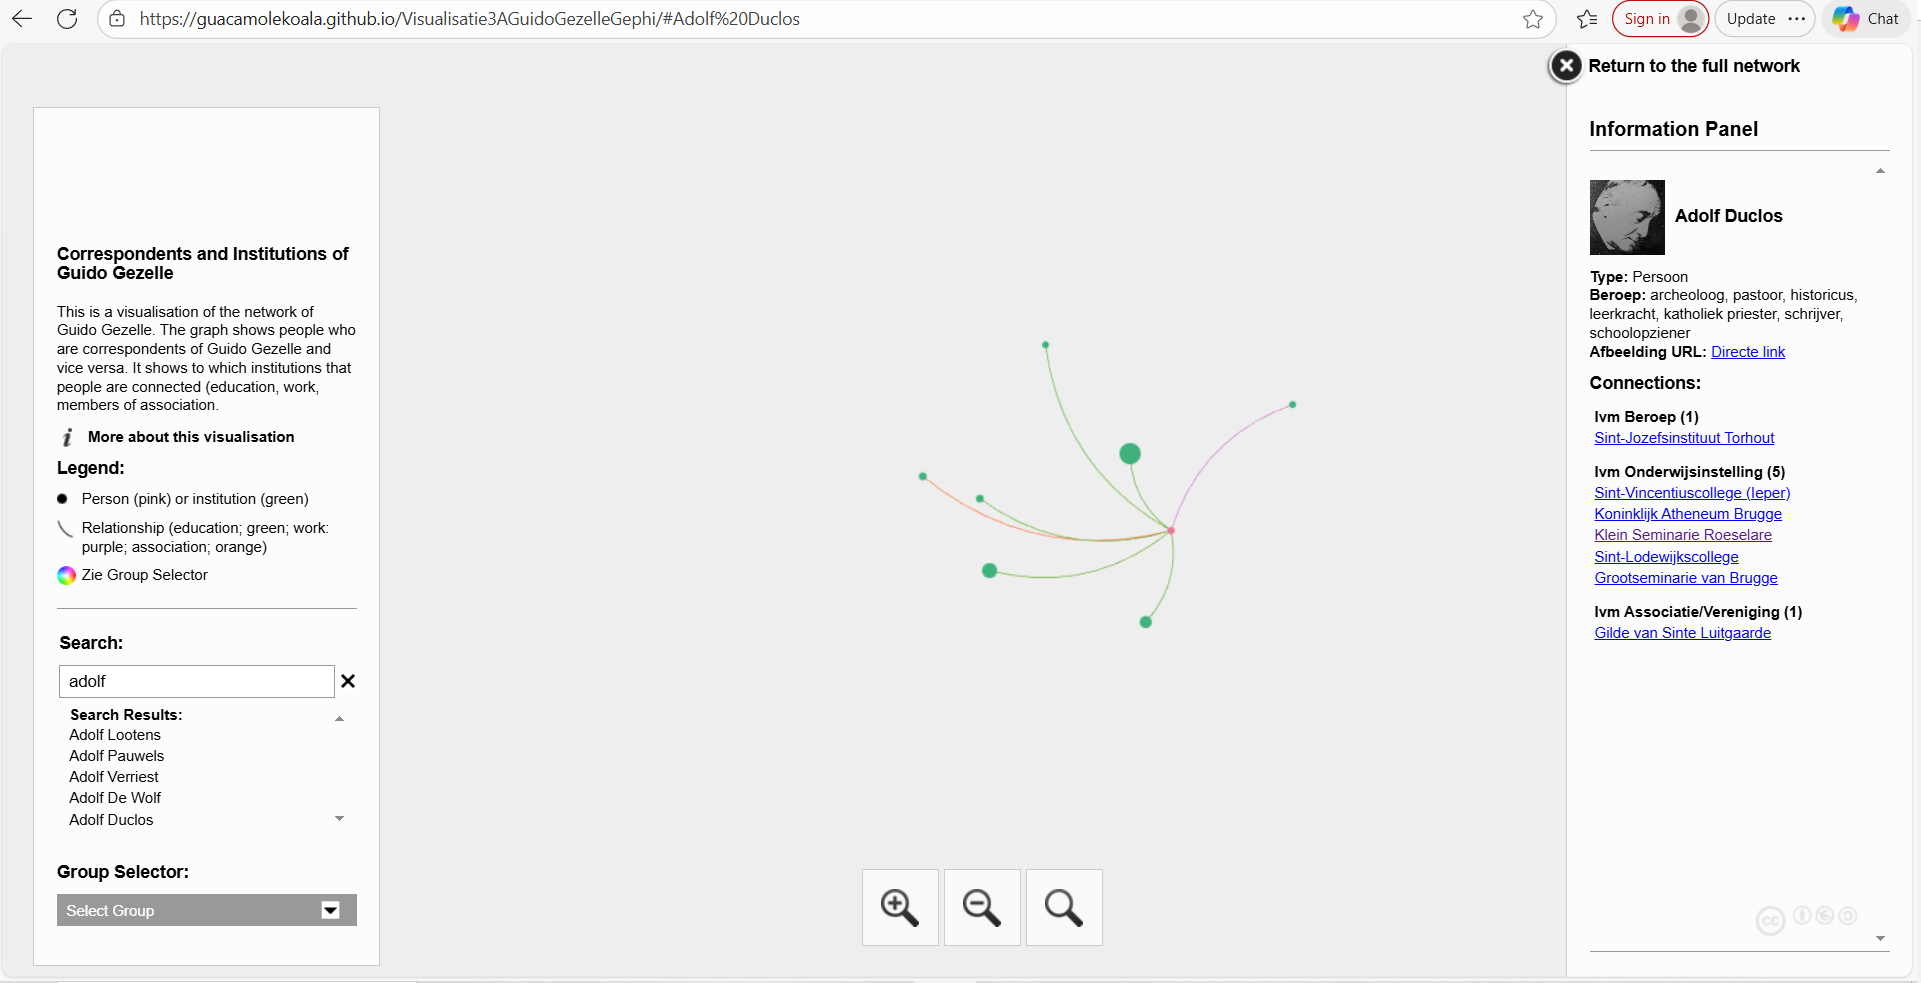

##AANPASSEN SCRIPT: VISUALISATIE 3B



Bij visualisatie 3b willen we graag de volgende zaken aanpassen na de Sigma-export. Ook hier zullen we de code daarvoor aanpassen van verschillende bestanden. 1)we zullen het paneel aan de rechterkant 'information pane' in plaats van 'information panel'. 2)Daarnaast willen we ook dat type, beroep, modularity in deze volgorde onder elkaar worden weergegeven wanneer er op een knoop wordt geklikt. 3) momenteel is de afbeelding nog wat groot soms in het rechtermenu. Dat willen we kunnen oplossen. 4) wanneer we de visualisatie bekijken, zien we teveel labels, waardoor de visualisatie onoverzichtelijk wordt. We willen minder of geen labels laten zien, tenzij we erover hooveren met de cursor. 5) evt willen we nog meer informatie laten zien zoals een link naar de afbeelding en een link naar het wikidata item van de knoop.

Door gebrek aan persoonlijke technische kennis, werd de hulp van Gemini 2.5 en 3.0 gevraagd. Op die manier zijn we aan de slag gegaan met de bestanden uit de Sigma-export. Een nuttige tip is om elk van deze problemen afzonderlijk en stap voor stap op te lossen door goede prompts op te stellen. Aangezien het ook mogelijk is bestanden door te sturen, hebben we de config.json, index.html, data.json en main.js laten analyseren. Door aanpassingen te maken in deze vier bestanden zijn alle problemen hierboven aangepast. Dat kan in Github zelf, door op de bestanden in de repository te klikken en vervolgens te bewerken. Door deze veranderingen te 'committen', voer je de aanpassingen door. Zo heb je een controle van verschillende versies indien er iets misgaat. Je kan ook beslissen om de aanpassingen via Notepad door te voeren en later op Github op te laden.

**1. Foutieve spelling 'information panel'**: het eerste probleem is simpel op te lossen door in de index.html te zoeken naar 'information pane' en deze simpelweg aan te passen naar 'information panel'. Vervolgens kun je het bestanden opnieuw opladen.



**2. aangepaste volgorde weergave attributen in de knopen**: in het aangepaste main.js-bestand is de code vervangen door een structuur die expliciet de prioriteit en volgorde van de gewenste attributen definieert. Hiervoor werd geprompt met Gemini 3.0

Bestand: mainadj.js Functie: nodeActive(a)

Zoek in de functie nodeActive naar de sectie waar de node-attributen worden verwerkt (rond regel 289 in de originele code) en vervang de gehele if (f.attributes)-blok.
JavaScript


```
// OUDE CODE (in main.js)
if (f.attributes) {
    var image_attribute = false;
    if (config.informationPanel.imageAttribute) {
        image_attribute=config.informationPanel.imageAttribute;
    }
    e = [];
    temp_array = [];
    g = 0;
    for (var attr in f.attributes) {
        var d = f.attributes[attr],
            h = "";
		if (attr!=image_attribute) {
            h = '<span><strong>' + attr + ':</strong> ' + d + '</span><br/>'
		}
        //temp_array.push(f.attributes[g].attr);
        e.push(h)
    }

    if (image_attribute) {
        //image_index = jQuery.inArray(image_attribute, temp_array);
        $GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
    } else {
        $GP.info_name.html("<div><span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
    }
    // Image field for attribute pane
    $GP.info_data.html(e.join("<br/>"))
}
```
Nieuwe Code (vervangende logica)

Plaats deze code in plaats van het bovenstaande blok in nodeActive(a):
JavaScript

```
// NIEUWE CODE (in mainadj.js)
if (f.attributes) {
  		var image_attribute = false;
  		if (config.informationPanel.imageAttribute) {
  			image_attribute=config.informationPanel.imageAttribute;
  		}

        var e = []; // Array voor de attribute display HTML-fragmenten
        var addedAttributes = {}; // Houd bij welke attributen al zijn toegevoegd
        
        // 1. Definieer de gewenste volgorde
        var priorityOrder = ['type', 'beroep', 'Modularity Class'];
        
        // 2. Voeg de geprioriteerde attributen toe in de gedefinieerde volgorde
        for (var i = 0; i < priorityOrder.length; i++) {
            var attrKey = priorityOrder[i];
            
            // Controleer of het attribuut bestaat in de data en niet het afbeelding-attribuut is
            if (f.attributes[attrKey] !== undefined && attrKey !== image_attribute) {
                var d = f.attributes[attrKey];
                
                // Maak de HTML string
                var h = '<span><strong>' + attrKey + ':</strong> ' + d + '</span>';
                
                e.push(h);
                addedAttributes[attrKey] = true;
            }
        }
        
        // 3. Voeg de overige attributen toe (alleen degenen die nog niet zijn toegevoegd en niet de afbeelding)
        for (var attr in f.attributes) {
            var d = f.attributes[attr];
            
            if (!addedAttributes[attr] && attr !== image_attribute) {
                var h = '<span><strong>' + attr + ':</strong> ' + d + '</span>';
                e.push(h);
            }
        }

        if (image_attribute) {
        	//image_index = jQuery.inArray(image_attribute, temp_array);
        	$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        } else {
        	$GP.info_name.html("<div><span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        }
        // Image field for attribute pane
        $GP.info_data.html(e.join("<br/>"))
    }

```


**3. Grootte van een afbeelding aanpassen**: ook hier werd hulp gevraagd aan Gemini. De grootte van de afbeelding wordt bepaald door de HTML-styling binnen de nodeActive functie in mainadj.js. We kunnen dit aanpassen door een vaste maximale hoogte of breedte in te stellen op de <img> tag. Hier is de aangepaste code die een maximale hoogte van 60 pixels instelt voor de afbeelding, waardoor deze als een thumbnail wordt weergegeven.

Zoek de regel in de sectie waar image_attribute waar is (if (image_attribute)) in mainadj.js:

JavaScript
```
// OUDE CODE (in mainadj.js - binnen if (image_attribute))
$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
```

Nieuwe Code (met vaste afmeting)

Vervang de style attribuutwaarde om een maximale hoogte in te stellen (bijvoorbeeld max-height:60px en max-width:60px om een duidelijke thumbnail te krijgen):

JavaScript:
```
// NIEUWE CODE (vervangende regel in mainadj.js)
$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle; max-height:60px; max-width:60px; margin-right: 10px;\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
```


**4. Minder labels laten verschijnen en verbindingen dikker maken**:dit kan simpelweg opgelost worden in het config.json-bestand. Hier kun je een waarde "labelThreshold" te veranderen van '10' in '100'. Je zal zelf wat moeten zoeken welke waarde precies goed is. Je kan hier ook de minimum en maximum 'edgesize' om de randen/verbindingen dikker te maken.


**5. Toevoegen van image link en wikidata link**: U moet het volledige if (f.attributes)-blok binnen de functie nodeActive(a) van uw bestand mainadj.js vervangen.

Code om te Verwijderen (in mainadj.js)

Zoek in de functie nodeActive(a) naar het volledige if (f.attributes) blok en verwijder het. De code ziet er ongeveer zo uit (afhankelijk van eerdere aanpassingen):
JavaScript

```
// Start van de code die u moet vervangen/verwijderen:
if (f.attributes) {
    var image_attribute = false;
    if (config.informationPanel.imageAttribute) {
        image_attribute=config.informationPanel.imageAttribute;
    }
    // ... hier staat de oude logica voor het verwerken van attributen,
    // de naam en het tonen van de afbeelding (mogelijk al deels aangepast)
    // ...
    // De laatste regel binnen deze if-blok is waarschijnlijk:
    $GP.info_data.html(e.join("<br/>"))
}
```

Nieuwe Code om te Plakken

Plak in plaats van het verwijderde blok de volgende code. Dit combineert: Volgorde: type, beroep, Modularity Class eerst. Thumbnail: max-height:60px; max-width:60px; voor de afbeelding. Links: Wikidata-link (via b.id) en de Afbeelding URL.

JavaScript

```
if (f.attributes) {
  		var image_attribute = false;
  		if (config.informationPanel.imageAttribute) {
  			image_attribute=config.informationPanel.imageAttribute;
  		}

        var e = []; // Array voor de attribute display HTML-fragmenten
        var addedAttributes = {}; // Houd bij welke attributen al zijn toegevoegd
        
        // 1. Definieer de gewenste volgorde
        var priorityOrder = ['type', 'beroep', 'Modularity Class'];
        
        // 2. Voeg de geprioriteerde attributen toe in de gedefinieerde volgorde
        for (var i = 0; i < priorityOrder.length; i++) {
            var attrKey = priorityOrder[i];
            
            // Controleer of het attribuut bestaat in de data en niet het afbeelding-attribuut is
            if (f.attributes[attrKey] !== undefined && attrKey !== image_attribute) {
                var d = f.attributes[attrKey];
                
                // Maak de HTML string
                var h = '<span><strong>' + attrKey + ':</strong> ' + d + '</span>';
                
                e.push(h);
                addedAttributes[attrKey] = true;
            }
        }
        
        // 3. Voeg de overige attributen toe
        for (var attr in f.attributes) {
            var d = f.attributes[attr];
            
            if (!addedAttributes[attr] && attr !== image_attribute) {
                var h = '<span><strong>' + attr + ':</strong> ' + d + '</span>';
                e.push(h);
            }
        }

        // --- NIEUWE LOGICA VOOR LINKS ---
        
        // 4. Voeg de Wikidata link toe (gebruikt de node ID als Q-ID)
        var qid = b.id;
        // We gaan ervan uit dat de node ID (b.id) de Q-ID is, en de link is naar de hoofdnaamruimte
        if (qid && qid.match(/^Q[0-9]+$/i)) {
            var wikidata_url = 'https://www.wikidata.org/wiki/' + qid;
            var wikidata_html = '<span><strong>Wikidata:</strong> <a href="' + wikidata_url + '" target="_blank">Bekijk item (' + qid + ')</a></span>';
            e.push(wikidata_html);
        }
        
        // 5. Voeg de Afbeelding URL link toe
        if (image_attribute && f.attributes[image_attribute]) {
            var image_url = f.attributes[image_attribute];
            var image_link_html = '<span><strong>Afbeelding URL:</strong> <a href="' + image_url + '" target="_blank">Directe link</a></span>';
            e.push(image_link_html);
        }

        // --- EINDE NIEUWE LOGICA ---

        // De thumbnail-weergave (reeds aangepast voor max-height/width)
        if (image_attribute) {
        	$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle; max-height:60px; max-width:60px; margin-right: 10px;\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        } else {
        	$GP.info_name.html("<div><span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        }
        
        // Geef alle attributen en links weer, gescheiden door <br/>
        $GP.info_data.html(e.join("<br/>"))
    }
```


Nadat je de code hebt aangepast, kun je steeds opnieuw naar de webpagina gaan om te kijken of de veranderingen goed zijn doorgevoegd. Je wisselt dus af tussen aanpassingen maken in de code, deze opladen via commit en kijken naar de website met de visualisatie.

Opmerking: het kan nuttig zijn af te wisselen van browser of op verschillende toestellen te testen. Soms vernieuwen de gegevens van de webpagina niet snel door het opslaan van cookies/cache/files. Daardoor haalt je browser niet de meest actuele versie van de website op (met je aanpassingen). Het is belangrijk hier goed op te letten en soms iets langer te wachten dan dat Github indiceert.

Opmerking:
Op elk moment kan de dataset aangepast worden door op github naar het bestand 'data.json' te gaan en dit te vervangen door een nieuwe export vanuit Gephi (of elders).
De titel, korte en uitgebreide beschrijving, enzovoort kunnen eenvoudig aangepast worden in het config.json of index.html via Github of een andere editor.
Ook de algemene werking van de interface kan aangepast worden via het main.js- bestand. Ook dit kan vervangen worden of aangevuld worden waar nodig met nieuwe code.

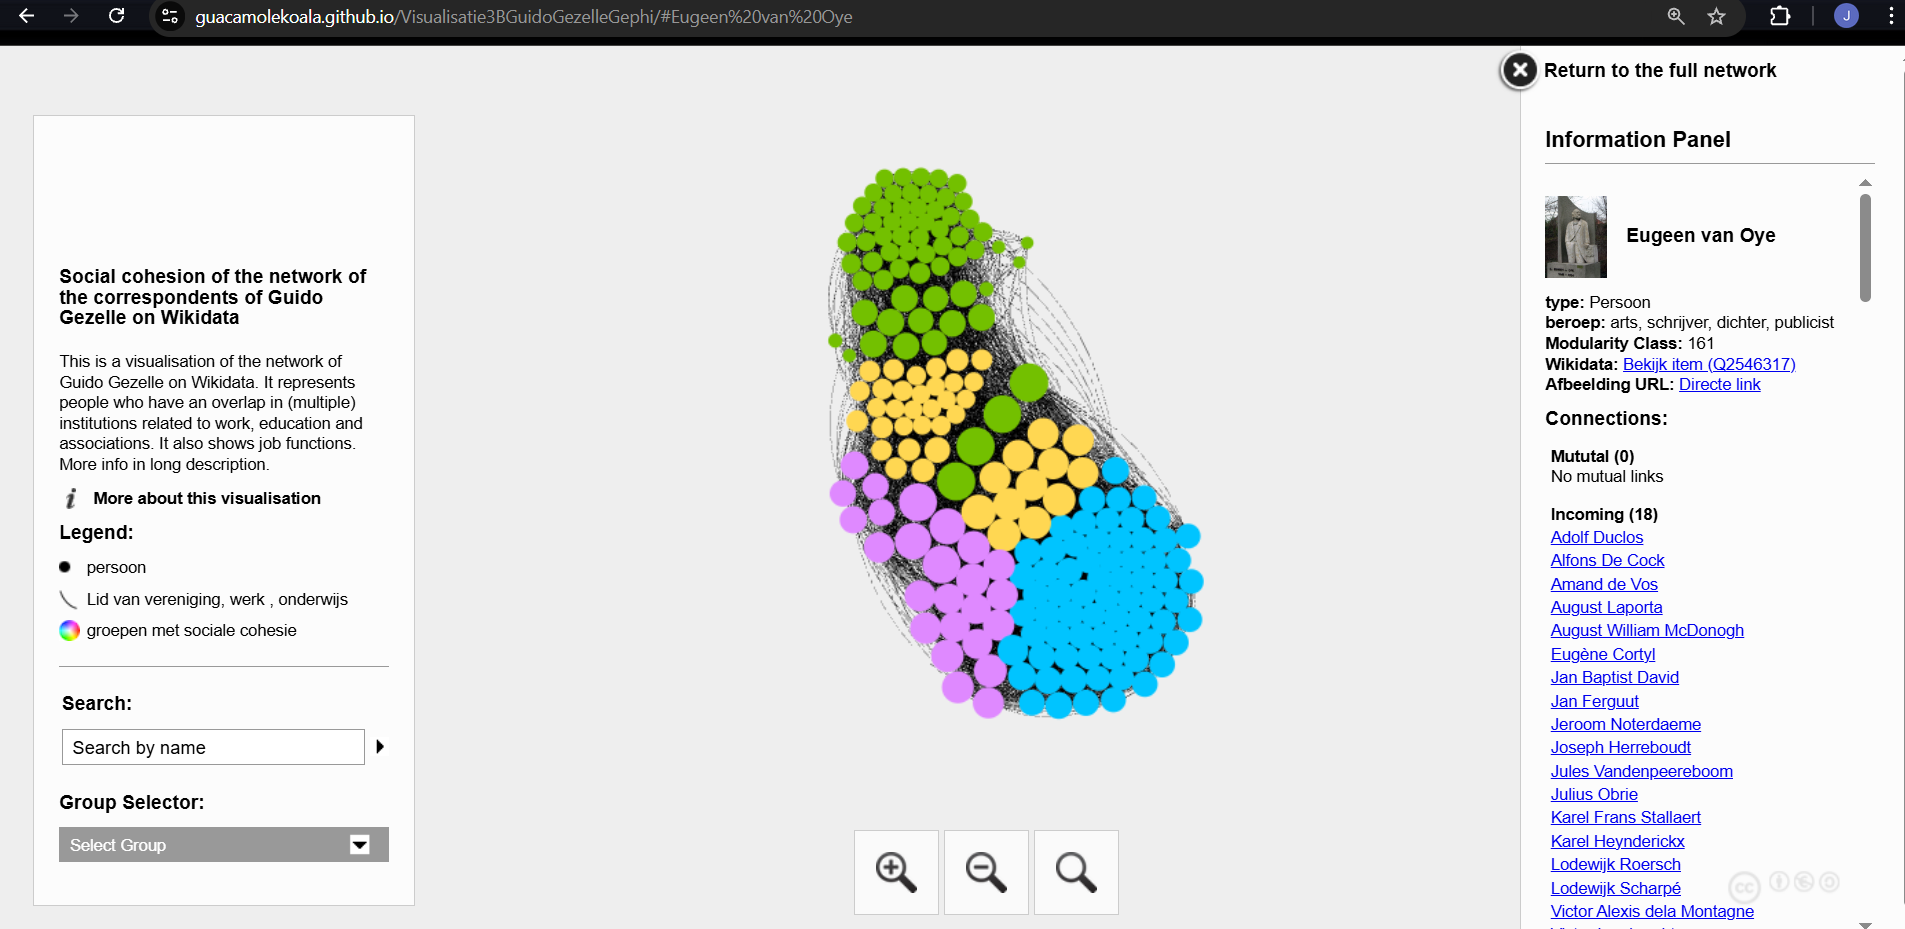

##FINAAL RESULTAAT: VISUALISATIE 3A


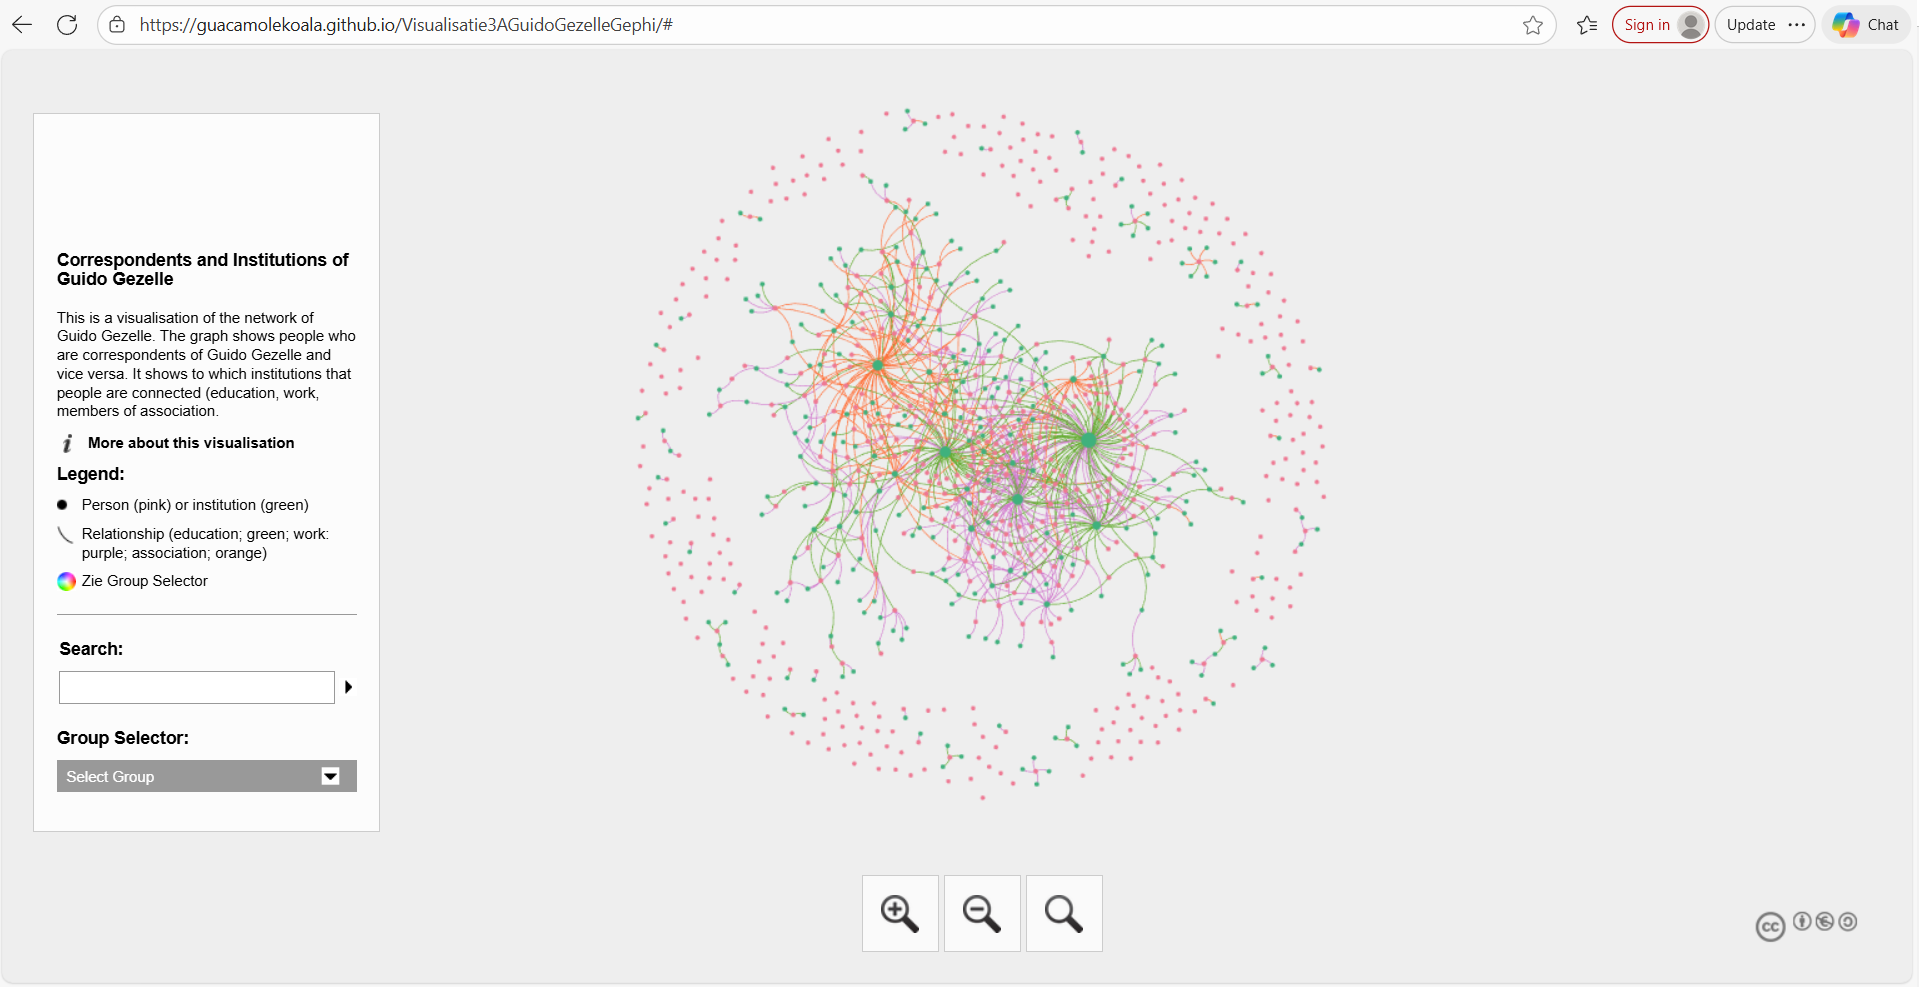

https://guacamolekoala.github.io/Visualisatie3AGuidoGezelleGephi/

In deze handleiding werd een visualisatie gemaakt op basis van beschikbare data omtrent Guido Gezelle.
Eerst werden enkele queries ontworpen. Daarna werden deze via Spreadsheets omgezet naar een knopenbestand en een verbindingenbestand. Daarna werd getoond hoe deze bestanden opgeladen worden in Gephi en er een visualisatie van gemaakt wordt. Er werd stilgestaan bij de layout, alsook bij de export via Sigma. In een laatste fase werd de interactieve visualisatie online beschikbaar gemaakt als Github-webpagina. Met behulp van generatieve AI, in dit geval Gemini, werd de code aangepast om wat meer functionaliteit toe te voegen.

##FINAAL RESULTAAT: VISUALISATIE 3B

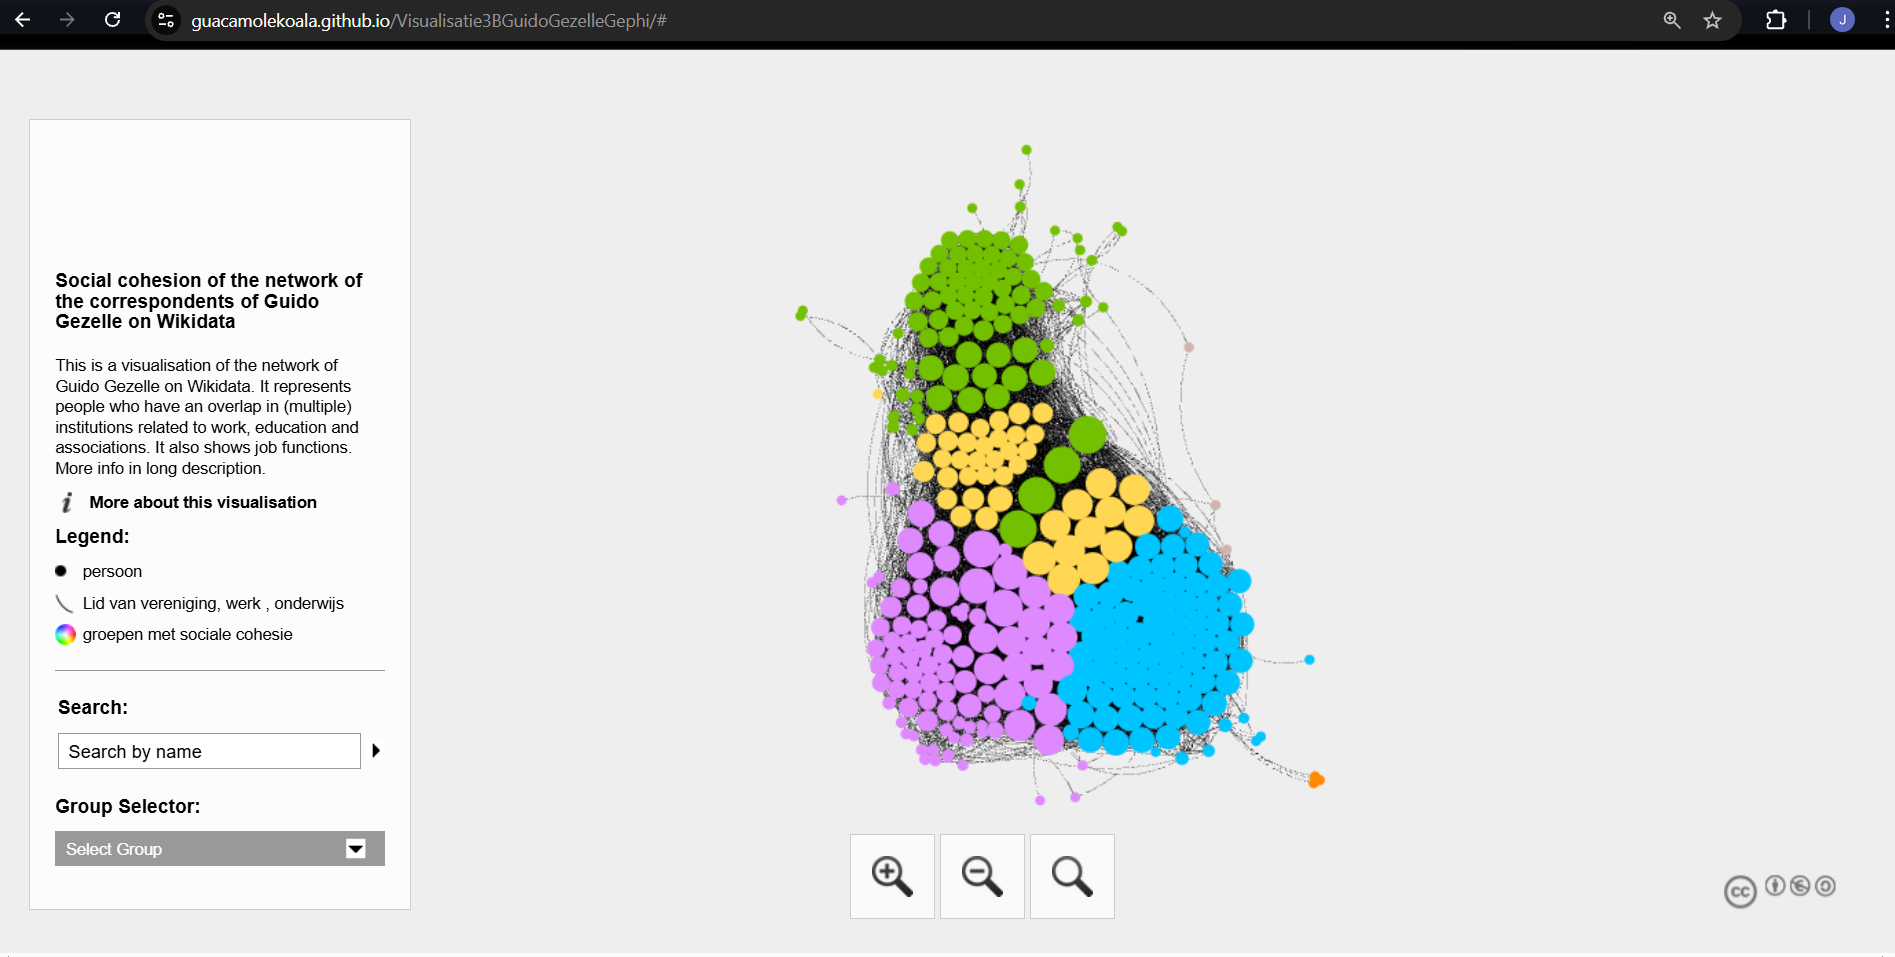

https://guacamolekoala.github.io/Visualisatie3BGuidoGezelleGephi/